# Convert timeseries of some SNOTEL stations to parquet
 
 
 requires ulmo:
 mamba create -n ulmo ulmo shapely geopandas pyarrow folium ipykernel 
 
 https://snowex-2021.hackweek.io/tutorials/geospatial/SNOTEL_query.html
 
 https://uwgda-jupyterbook.readthedocs.io/en/latest/modules/08_Vector_TimeSeries_SNOTEL/08_Vector_TimeSeries_SNOTEL_prep.html

In [11]:
import ulmo
import pandas as pd
import geopandas as gpd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [12]:
%config InlineBackend.figure_format='retina'

In [13]:
#This is the latest CUAHSI API endpoint
wsdlurl = 'https://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL'

In [14]:
# Load saved database
gf = gpd.read_parquet('snotel-sites.geoparquet')
gf.head()

,name,elevation_m,latitude,longitude,county,state,beginDate,endDate,isActive,geometry
code,,,,,,,,,,
301_CA_SNTL,Adin Mtn,1886.712036,41.235828,-120.791924,Modoc,California,1983-10-01,2100-01-01,True,POINT (-120.79192 41.23583)
907_UT_SNTL,Agua Canyon,2712.719971,37.522171,-112.271179,Kane,Utah,1994-10-01,2100-01-01,True,POINT (-112.27118 37.52217)
916_MT_SNTL,Albro Lake,2529.840088,45.597229,-111.959023,Madison,Montana,1996-09-01,2100-01-01,True,POINT (-111.95902 45.59723)
1267_AK_SNTL,Alexander Lake,48.768002,61.749668,-150.889664,Matanuska-Susitna,Alaska,2014-08-28,2100-01-01,True,POINT (-150.88966 61.74967)
908_WA_SNTL,Alpine Meadows,1066.800049,47.779572,-121.698471,King,Washington,1994-09-01,2100-01-01,True,POINT (-121.69847 47.77957)


In [15]:
%%time

# Get Variables available for a specific station
sitecode = f'SNOTEL:{gf.index[0]}'

ulmo.cuahsi.wof.get_site_info(wsdlurl, sitecode)['series'].keys()

CPU times: user 65.8 ms, sys: 1.8 ms, total: 67.6 ms
Wall time: 964 ms


dict_keys(['SNOTEL:BATT_D', 'SNOTEL:BATT_H', 'SNOTEL:PRCP_y', 'SNOTEL:PRCP_sm', 'SNOTEL:PRCP_m', 'SNOTEL:PRCP_wy', 'SNOTEL:PRCPSA_y', 'SNOTEL:PRCPSA_D', 'SNOTEL:PRCPSA_sm', 'SNOTEL:PRCPSA_m', 'SNOTEL:PRCPSA_wy', 'SNOTEL:PREC_sm', 'SNOTEL:PREC_m', 'SNOTEL:PREC_wy', 'SNOTEL:SNWD_D', 'SNOTEL:SNWD_sm', 'SNOTEL:SNWD_H', 'SNOTEL:SNWD_m', 'SNOTEL:TAVG_y', 'SNOTEL:TAVG_D', 'SNOTEL:TAVG_sm', 'SNOTEL:TAVG_m', 'SNOTEL:TAVG_wy', 'SNOTEL:TMAX_y', 'SNOTEL:TMAX_D', 'SNOTEL:TMAX_sm', 'SNOTEL:TMAX_m', 'SNOTEL:TMAX_wy', 'SNOTEL:TMIN_y', 'SNOTEL:TMIN_D', 'SNOTEL:TMIN_sm', 'SNOTEL:TMIN_m', 'SNOTEL:TMIN_wy', 'SNOTEL:TOBS_D', 'SNOTEL:TOBS_sm', 'SNOTEL:TOBS_H', 'SNOTEL:TOBS_m', 'SNOTEL:WTEQ_D', 'SNOTEL:WTEQ_sm', 'SNOTEL:WTEQ_H', 'SNOTEL:WTEQ_m'])

In [16]:
# NOTE: not all stations will have same observations, for example: 
# https://uwgda-jupyterbook.readthedocs.io/en/latest/modules/08_Vector_TimeSeries_SNOTEL/08_SNOTEL_download.html
#Note that the water equivalent (WTEQ_D) measurements from snow pillows extend much farther back in time, back to the early 1980s, before the ultrasonic snow depth instruments were incorporated across the network. These are better to use for long-term studies.


In [17]:
# Get detailed information on a specific variable

#Hourly SWE
#variablecode = 'SNOTEL:WTEQ_H'
#Hourly snow depth
#variablecode = 'SNOTEL:SNWD_H'

#Daily SWE
#variablecode = 'SNOTEL:WTEQ_D'
#Daily snow depth
variablecode = 'SNOTEL:SNWD_D'
ulmo.cuahsi.wof.get_variable_info(wsdlurl, variablecode)

{'value_type': 'Field Observation',
 'data_type': 'Continuous',
 'general_category': 'Soil',
 'sample_medium': 'Snow',
 'no_data_value': '-9999',
 'speciation': 'Not Applicable',
 'code': 'SNWD_D',
 'id': '176',
 'name': 'Snow depth',
 'vocabulary': 'SNOTEL',
 'time': {'is_regular': True,
  'interval': '1',
  'units': {'abbreviation': 'd',
   'code': '104',
   'name': 'day',
   'type': 'Time'}},
 'units': {'abbreviation': 'in',
  'code': '49',
  'name': 'international inch',
  'type': 'Length'}}

In [18]:
ulmo.cuahsi.wof.get_variable_info(wsdlurl, 'SNOTEL:WTEQ_D') # Take note of units! (inches)
# # convert inches to meters
#df['value'] /= 39.3701

{'value_type': 'Field Observation',
 'data_type': 'Continuous',
 'general_category': 'Soil',
 'sample_medium': 'Snow',
 'no_data_value': '-9999',
 'speciation': 'Not Applicable',
 'code': 'WTEQ_D',
 'id': '310',
 'name': 'Snow water equivalent',
 'vocabulary': 'SNOTEL',
 'time': {'is_regular': True,
  'interval': '1',
  'units': {'abbreviation': 'd',
   'code': '104',
   'name': 'day',
   'type': 'Time'}},
 'units': {'abbreviation': 'in',
  'code': '49',
  'name': 'international inch',
  'type': 'Length'}}

In [19]:
variablecode='SNOTEL:SNWD_D'
start_date='2014-01-01' 
today = datetime.today().strftime('%Y-%m-%d')
site_values = ulmo.cuahsi.wof.get_values(wsdlurl, sitecode, variablecode, start=start_date, end=today) #dictionary of dictionaries!

In [44]:
def snotel_fetch(sitecode, variablecode='SNWD_D', start_date='2014-01-01', end_date=today):
    values_df = None
    try:
        site_values = ulmo.cuahsi.wof.get_values(wsdlurl, 'SNOTEL:'+sitecode, 'SNOTEL:'+variablecode, start=start_date, end=end_date)
        values_df = pd.DataFrame.from_dict(site_values['values'])

        values_df['datetime'] = pd.to_datetime(values_df['datetime'], utc=True)
        values_df = values_df.set_index('datetime')
        
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        raise
        print("Unable to fetch %s" % variablecode)

    return values_df

In [23]:
%%time
sitecode='622_CO_SNTL'
var = 'SNWD_D'
df = snotel_fetch(sitecode, variablecode=var, start_date='2014-01-01', end_date=datetime.today())
df.shape

CPU times: user 328 ms, sys: 1.01 ms, total: 329 ms
Wall time: 2.13 s


(3324, 8)

In [24]:
df.head()

,value,qualifiers,censor_code,date_time_utc,method_id,method_code,source_code,quality_control_level_code
datetime,,,,,,,,
2014-01-01 00:00:00+00:00,29,E,nc,2014-01-01T00:00:00,0,0,1,1
2014-01-02 00:00:00+00:00,29,V,nc,2014-01-02T00:00:00,0,0,1,1
2014-01-03 00:00:00+00:00,29,V,nc,2014-01-03T00:00:00,0,0,1,1
2014-01-04 00:00:00+00:00,29,E,nc,2014-01-04T00:00:00,0,0,1,1
2014-01-05 00:00:00+00:00,29,E,nc,2014-01-05T00:00:00,0,0,1,1


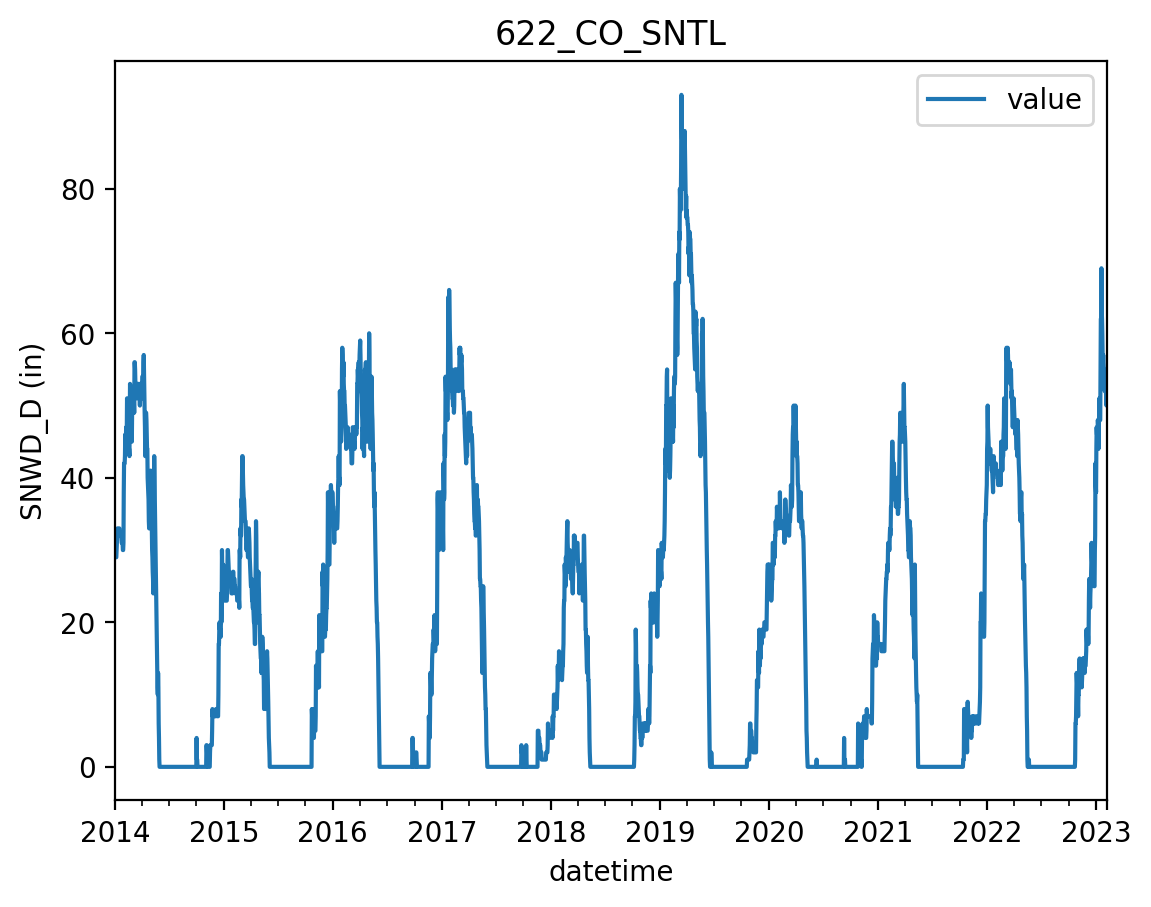

In [25]:
df['2014':].plot(y='value', title=sitecode, ylabel=var+' (in)');

In [26]:
%%time

# NOTE: ~1sec per decade of data

var = 'WTEQ_D'
df2 = snotel_fetch(sitecode, variablecode=var, start_date='2014-01-01', end_date=datetime.today())
df2.shape

CPU times: user 327 ms, sys: 3.4 ms, total: 330 ms
Wall time: 1.89 s


(3324, 8)

In [27]:
df2.head()

,value,qualifiers,censor_code,date_time_utc,method_id,method_code,source_code,quality_control_level_code
datetime,,,,,,,,
2014-01-01 00:00:00+00:00,6.5,E,nc,2014-01-01T00:00:00,0,0,1,1
2014-01-02 00:00:00+00:00,6.5,V,nc,2014-01-02T00:00:00,0,0,1,1
2014-01-03 00:00:00+00:00,6.5,V,nc,2014-01-03T00:00:00,0,0,1,1
2014-01-04 00:00:00+00:00,6.5,E,nc,2014-01-04T00:00:00,0,0,1,1
2014-01-05 00:00:00+00:00,6.5,E,nc,2014-01-05T00:00:00,0,0,1,1


In [28]:
#df2.qualifiers.unique()

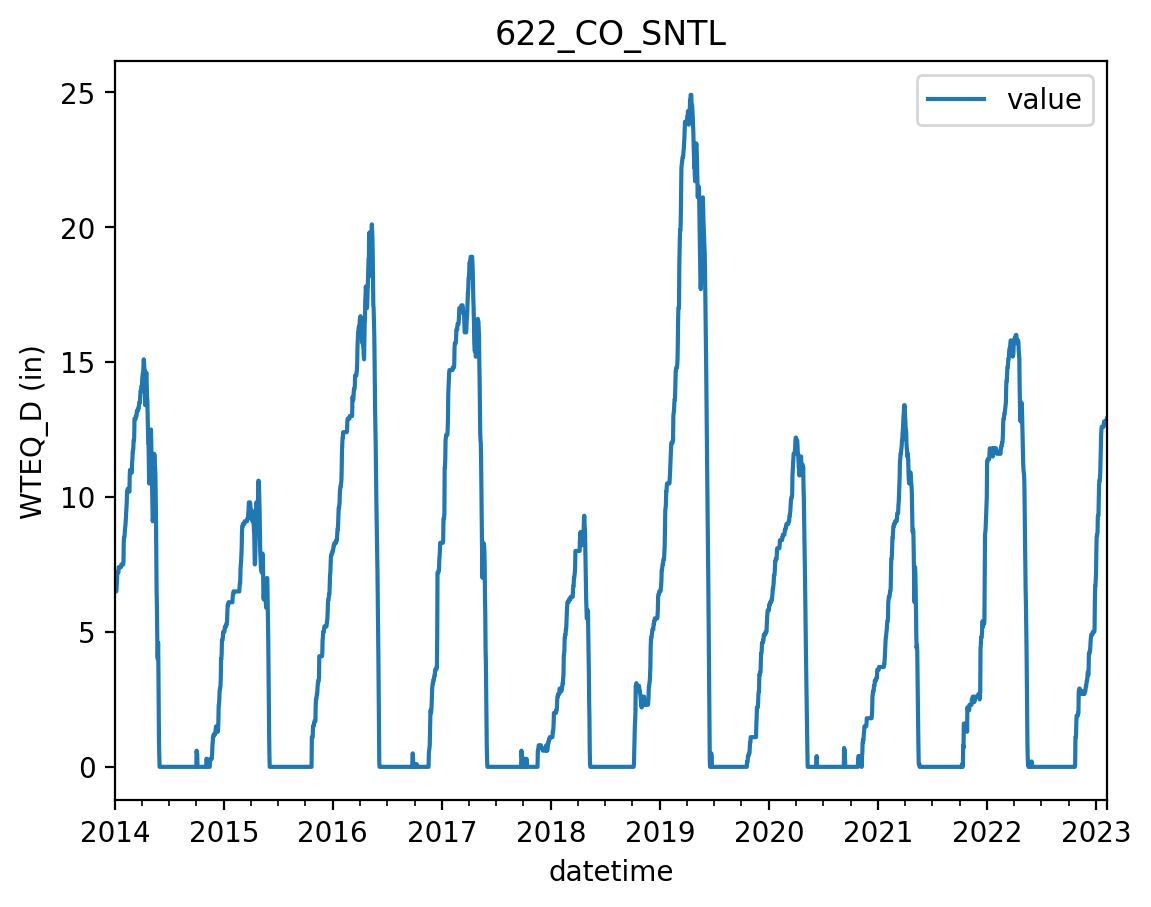

In [29]:
df2['2014':].plot(y='value', title=sitecode, ylabel=var+' (in)');

In [30]:
# Plot together by joining dataframes
tmp = df.rename(columns={'value':'swe'})['swe'].to_frame()
dfc = tmp.join(df2.rename(columns={'value':'depth'})['depth'])
dfc

,swe,depth
datetime,,
2014-01-01 00:00:00+00:00,29,6.5
2014-01-02 00:00:00+00:00,29,6.5
2014-01-03 00:00:00+00:00,29,6.5
2014-01-04 00:00:00+00:00,29,6.5
2014-01-05 00:00:00+00:00,29,6.5
...,...,...
2023-02-02 00:00:00+00:00,53,12.7
2023-02-03 00:00:00+00:00,52,12.7
2023-02-04 00:00:00+00:00,51,12.8


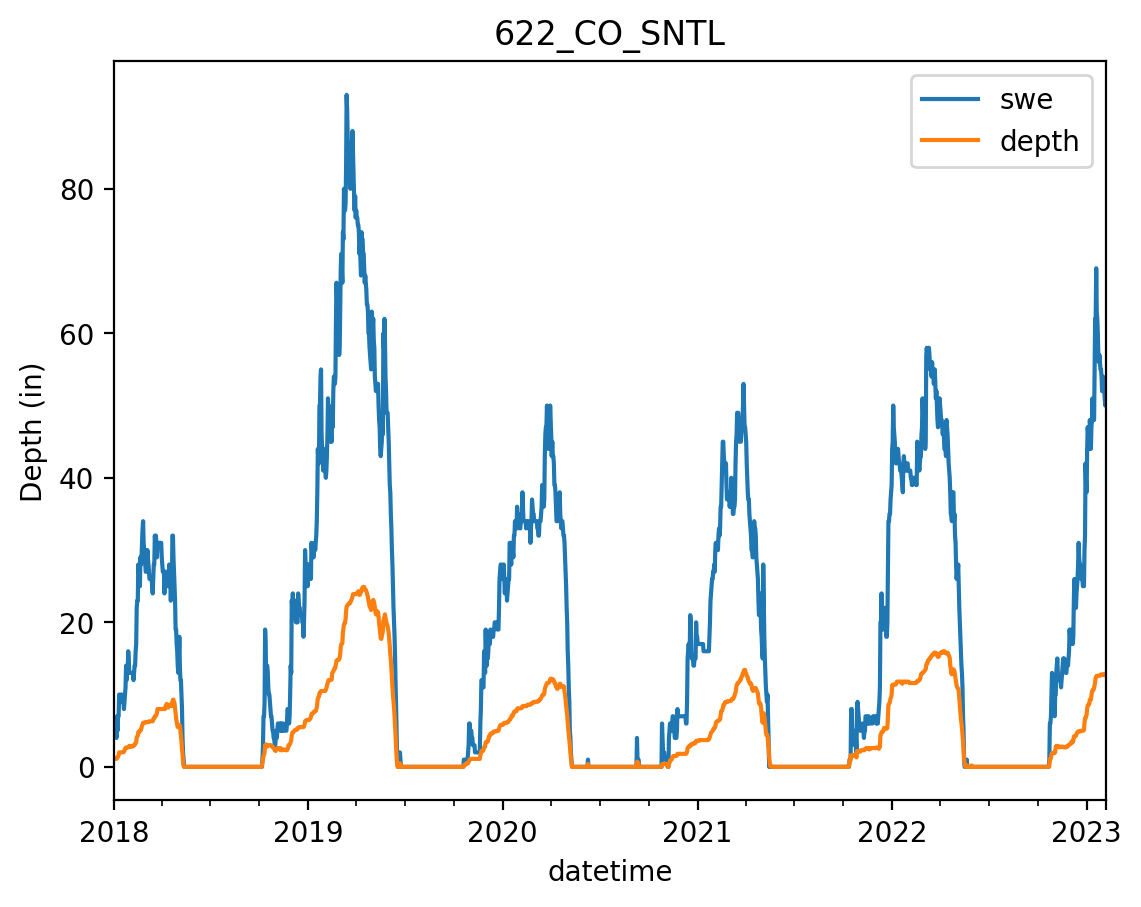

In [31]:
dfc['2018':].plot(title=sitecode, ylabel='Depth (in)'); #both in in

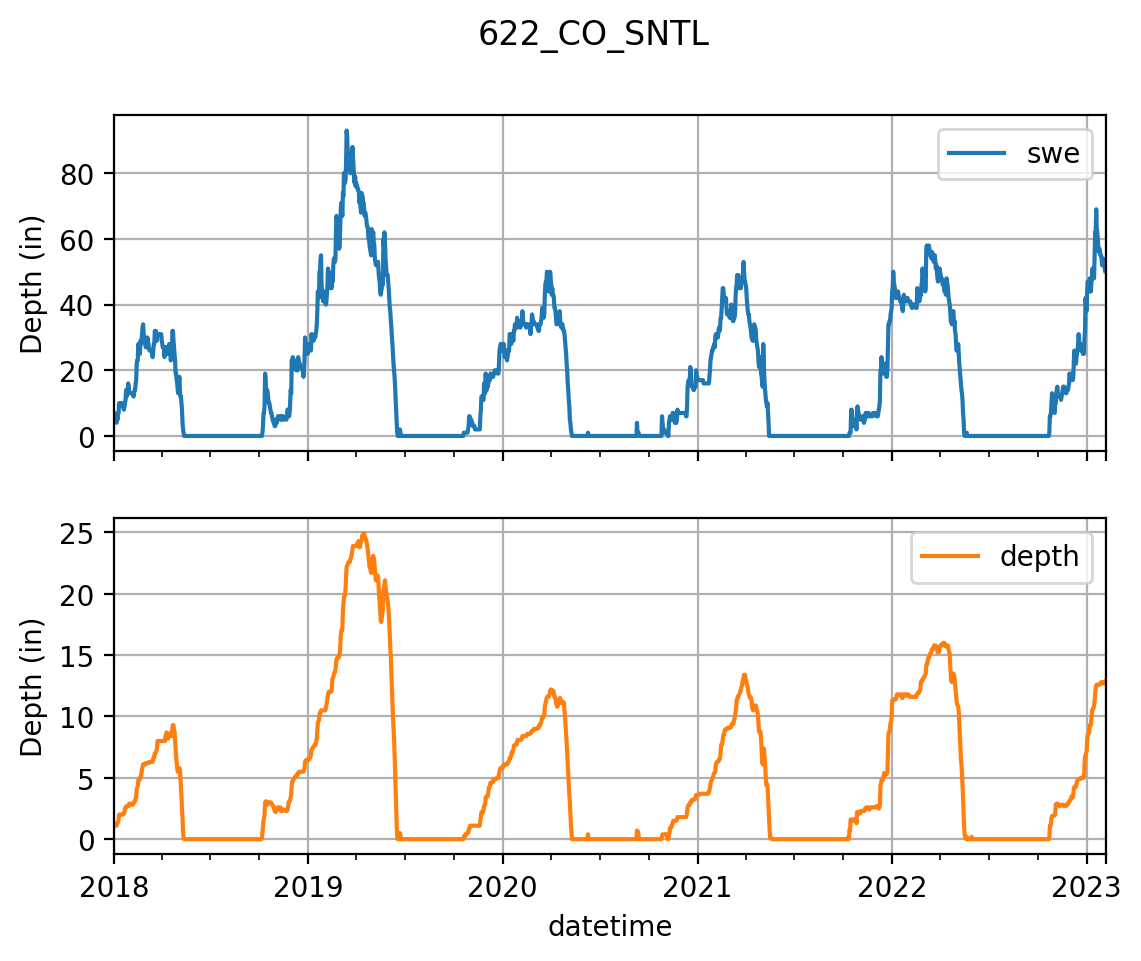

In [32]:
dfc['2018':].plot(subplots=True, grid=True, title=sitecode, ylabel='Depth (in)'); #both in in

In [39]:
# Construct a datset of all measured daily varibales for this station
station_info = ulmo.cuahsi.wof.get_site_info(wsdlurl, 'SNOTEL:'+sitecode)['series']
station_info.keys()

dict_keys(['SNOTEL:BATT_D', 'SNOTEL:BATT_H', 'SNOTEL:BATX_H', 'SNOTEL:PRCP_y', 'SNOTEL:PRCP_sm', 'SNOTEL:PRCP_m', 'SNOTEL:PRCP_wy', 'SNOTEL:PRCPSA_y', 'SNOTEL:PRCPSA_D', 'SNOTEL:PRCPSA_sm', 'SNOTEL:PRCPSA_m', 'SNOTEL:PRCPSA_wy', 'SNOTEL:PREC_sm', 'SNOTEL:PREC_m', 'SNOTEL:PREC_wy', 'SNOTEL:SNWD_D', 'SNOTEL:SNWD_sm', 'SNOTEL:SNWD_H', 'SNOTEL:SNWD_m', 'SNOTEL:TAVG_y', 'SNOTEL:TAVG_D', 'SNOTEL:TAVG_sm', 'SNOTEL:TAVG_m', 'SNOTEL:TAVG_wy', 'SNOTEL:TMAX_y', 'SNOTEL:TMAX_D', 'SNOTEL:TMAX_sm', 'SNOTEL:TMAX_m', 'SNOTEL:TMAX_wy', 'SNOTEL:TMIN_y', 'SNOTEL:TMIN_D', 'SNOTEL:TMIN_sm', 'SNOTEL:TMIN_m', 'SNOTEL:TMIN_wy', 'SNOTEL:TOBS_D', 'SNOTEL:TOBS_sm', 'SNOTEL:TOBS_H', 'SNOTEL:TOBS_m', 'SNOTEL:WTEQ_D', 'SNOTEL:WTEQ_sm', 'SNOTEL:WTEQ_H', 'SNOTEL:WTEQ_m'])

In [40]:
for key,val in station_info.items():
    print(key, val['variable']['name'])

SNOTEL:BATT_D Battery voltage
SNOTEL:BATT_H Battery voltage
SNOTEL:BATX_H Battery voltage
SNOTEL:PRCP_y Precipitation
SNOTEL:PRCP_sm Precipitation
SNOTEL:PRCP_m Precipitation
SNOTEL:PRCP_wy Precipitation
SNOTEL:PRCPSA_y Precipitation snow adjusted
SNOTEL:PRCPSA_D Precipitation snow adjusted
SNOTEL:PRCPSA_sm Precipitation snow adjusted
SNOTEL:PRCPSA_m Precipitation snow adjusted
SNOTEL:PRCPSA_wy Precipitation snow adjusted
SNOTEL:PREC_sm Precipitation
SNOTEL:PREC_m Precipitation
SNOTEL:PREC_wy Precipitation
SNOTEL:SNWD_D Snow depth
SNOTEL:SNWD_sm Snow depth
SNOTEL:SNWD_H Snow depth
SNOTEL:SNWD_m Snow depth
SNOTEL:TAVG_y Temperature
SNOTEL:TAVG_D Temperature
SNOTEL:TAVG_sm Temperature
SNOTEL:TAVG_m Temperature
SNOTEL:TAVG_wy Temperature
SNOTEL:TMAX_y Temperature
SNOTEL:TMAX_D Temperature
SNOTEL:TMAX_sm Temperature
SNOTEL:TMAX_m Temperature
SNOTEL:TMAX_wy Temperature
SNOTEL:TMIN_y Temperature
SNOTEL:TMIN_D Temperature
SNOTEL:TMIN_sm Temperature
SNOTEL:TMIN_m Temperature
SNOTEL:TMIN_wy Tem

In [148]:
station_info['SNOTEL:PRCPSA_D'] #wy = water? #sm semi-monthly? #m = ed month?, hourly...
# TOBS_D vs TAVG_D?
# Soil moisture sensors at some stations
# PREC vs PRCP vs PRCPSA? precipitation accumulation (PREC), precipitation increment (PRCP), snow-adjusted precipitation increment (PRCPSA),

# NOTE: 'Element Descriptions on web-based reports have more detail for example
# TOBS = Instantaneously observed air temperature (Instantaneous - Start of Day)
# TAVG = Average air temperature - sub-hourly sampling frequency (Day)

# https://www.nrcs.usda.gov/wps/portal/wcc/home/snowClimateMonitoring/temperature/temperatureBiasCorrection/
# But also SNOTEL air temperature data contains a known bias. This bias is rooted in the sensor conversion equation and varies through the output range. Solutions are in development. For more information go to Air Temperature Bias Correction ! 


# A nice report 
#https://www.epa.gov/climate-indicators/climate-change-indicators-snowfall

{'variable': {'value_type': 'Field Observation',
  'data_type': 'Incremental',
  'general_category': 'Soil',
  'sample_medium': 'Precipitation',
  'no_data_value': '-9999',
  'speciation': 'Not Applicable',
  'code': 'PRCPSA_D',
  'id': '18',
  'name': 'Precipitation snow adjusted',
  'vocabulary': 'SNOTEL',
  'time': {'is_regular': True,
   'interval': '1',
   'units': {'abbreviation': 'd',
    'code': '104',
    'name': 'day',
    'type': 'Time'}},
  'units': {'abbreviation': 'in',
   'code': '49',
   'name': 'international inch',
   'type': 'Length'}},
 '{http://www.cuahsi.org/water_ml/1.1/}method': {'method_id': '0',
  'method_description': 'No method specified'},
 '{http://www.cuahsi.org/water_ml/1.1/}source': {'source_id': '1',
  'organization': 'United States Department of Agriculture Natural Resources Conservation Service',
  'source_description': 'Snow Telemetry (SNOTEL)',
  'citation': 'USDA NRCS Snow Telemetry (SNOTEL) Network'},
 '{http://www.cuahsi.org/water_ml/1.1/}qualit

In [41]:
# Ok, so get daily temperatures for this station:
[x for x in station_info.keys() if x.endswith('_D')]

['SNOTEL:BATT_D',
 'SNOTEL:PRCPSA_D',
 'SNOTEL:SNWD_D',
 'SNOTEL:TAVG_D',
 'SNOTEL:TMAX_D',
 'SNOTEL:TMIN_D',
 'SNOTEL:TOBS_D',
 'SNOTEL:WTEQ_D']

In [45]:
%%time

# NOTE: ~1sec per decade of data

var = 'PRCPSA_D'
df2 = snotel_fetch(sitecode, variablecode=var, start_date='2014-01-01', end_date=datetime.today())
df2.shape

CPU times: user 319 ms, sys: 13.2 ms, total: 332 ms
Wall time: 2.18 s


(3323, 8)

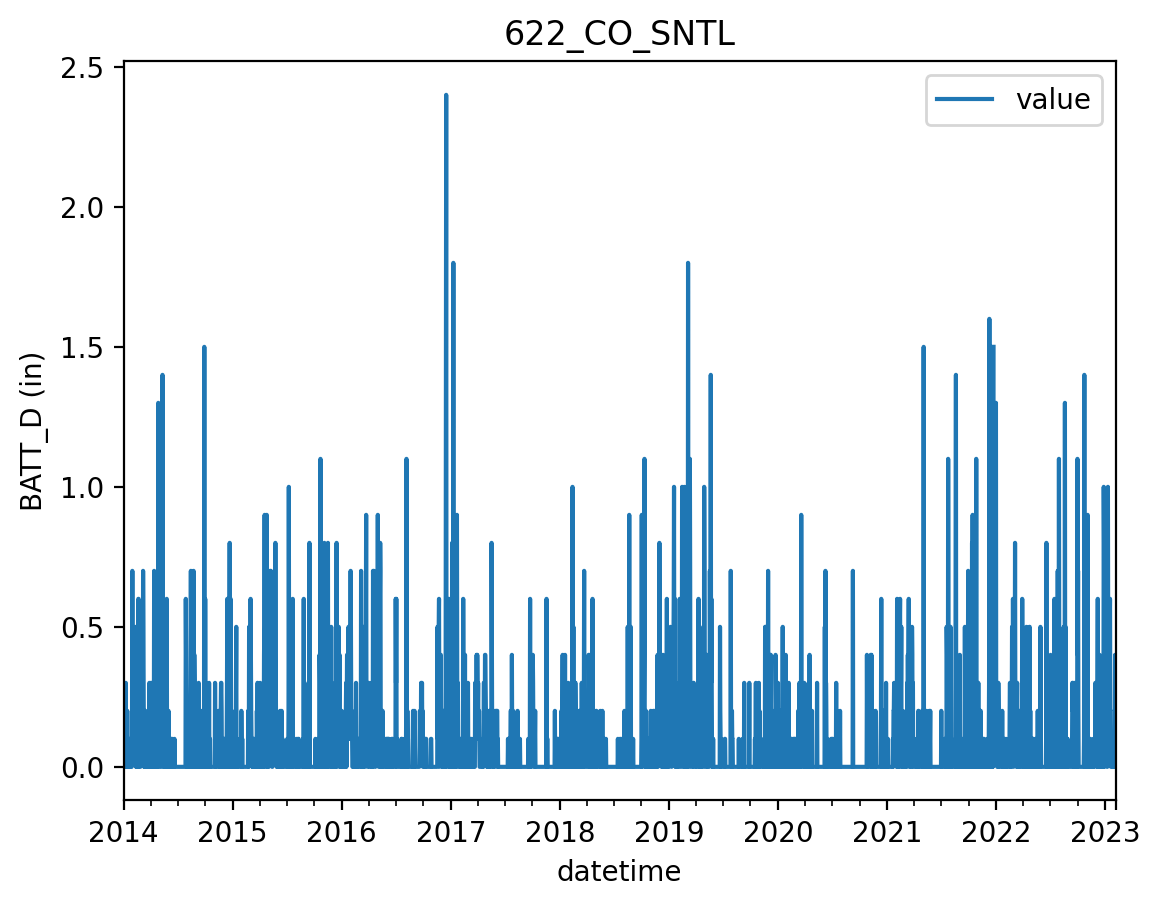

In [62]:
df2.head()
df2['2014':].plot(y='value', title=sitecode, ylabel=var+' (in)');

In [65]:
# WebFault: Server raised fault: 'Object reference not set to an instance of an object.'
#var='BATT_D' # <suds.sax.document.Document object at 0x7fdaa566b520>
#tmp = snotel_fetch(sitecode, variablecode=var, start_date='2014-01-01', end_date=datetime.today())
#tmp['2014':].plot(y='value', title=sitecode, ylabel=var);

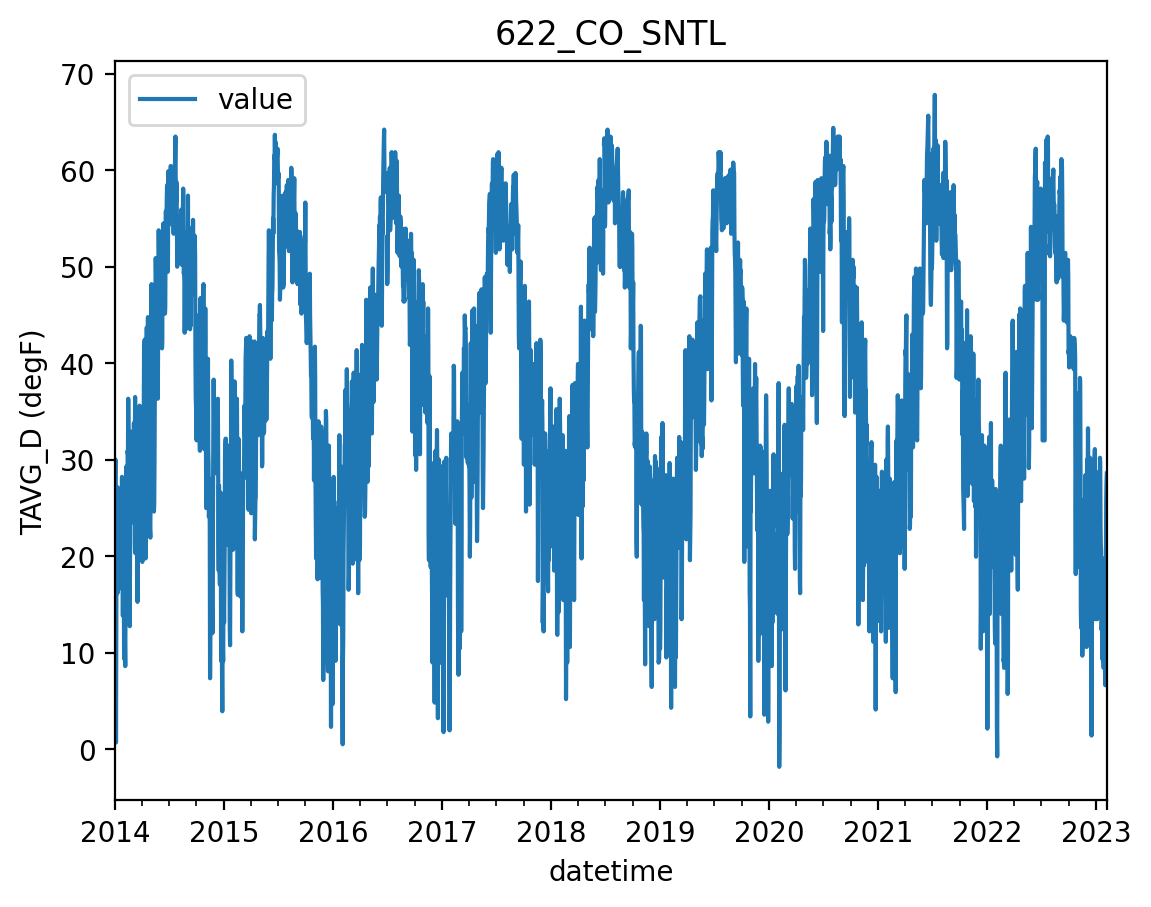

In [63]:
var = 'TAVG_D'
tmp = snotel_fetch(sitecode, variablecode=var, start_date='2014-01-01', end_date=datetime.today())
tmp['2014':].plot(y='value', title=sitecode, ylabel=var+' (degF)');

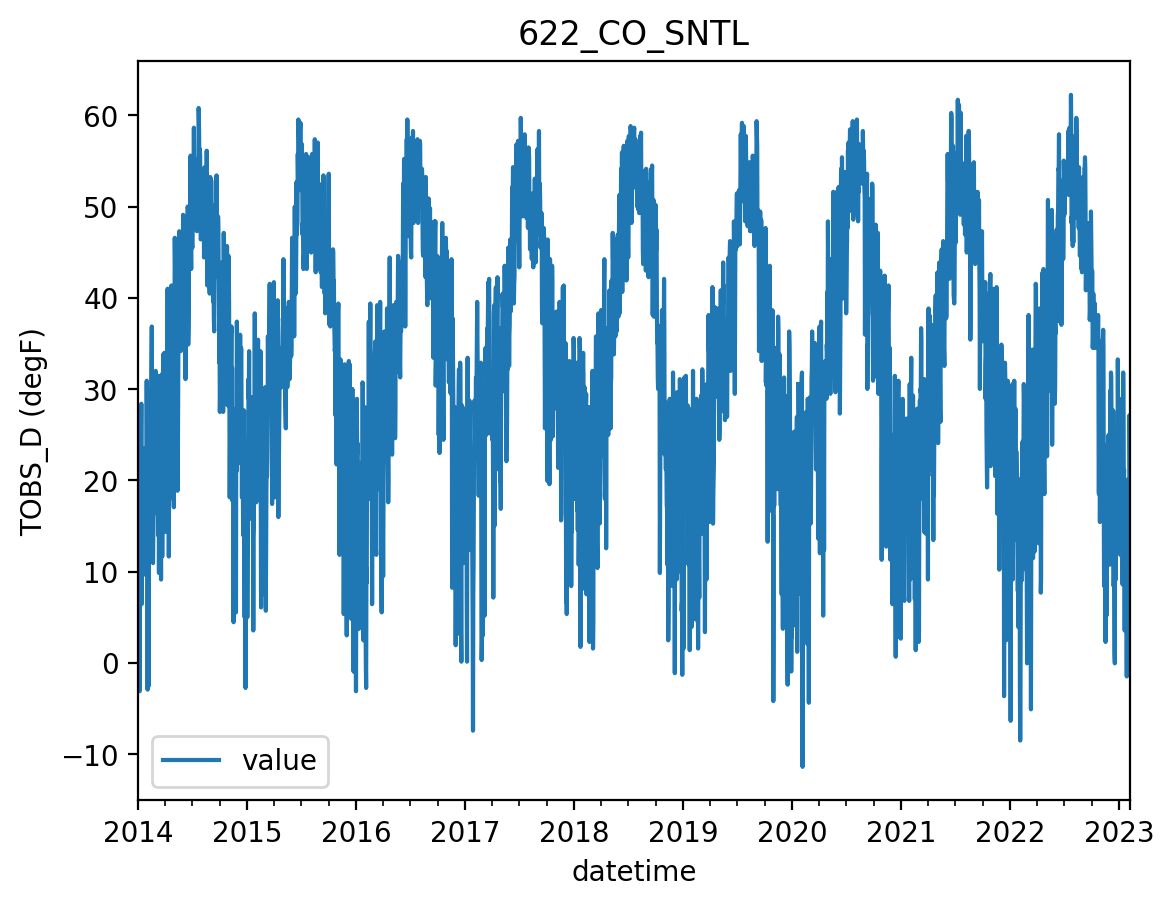

In [49]:
var = 'TOBS_D'
tmp = snotel_fetch(sitecode, variablecode=var, start_date='2014-01-01', end_date=datetime.today())
tmp['2014':].plot(y='value', title=sitecode, ylabel=var+' (degF)');

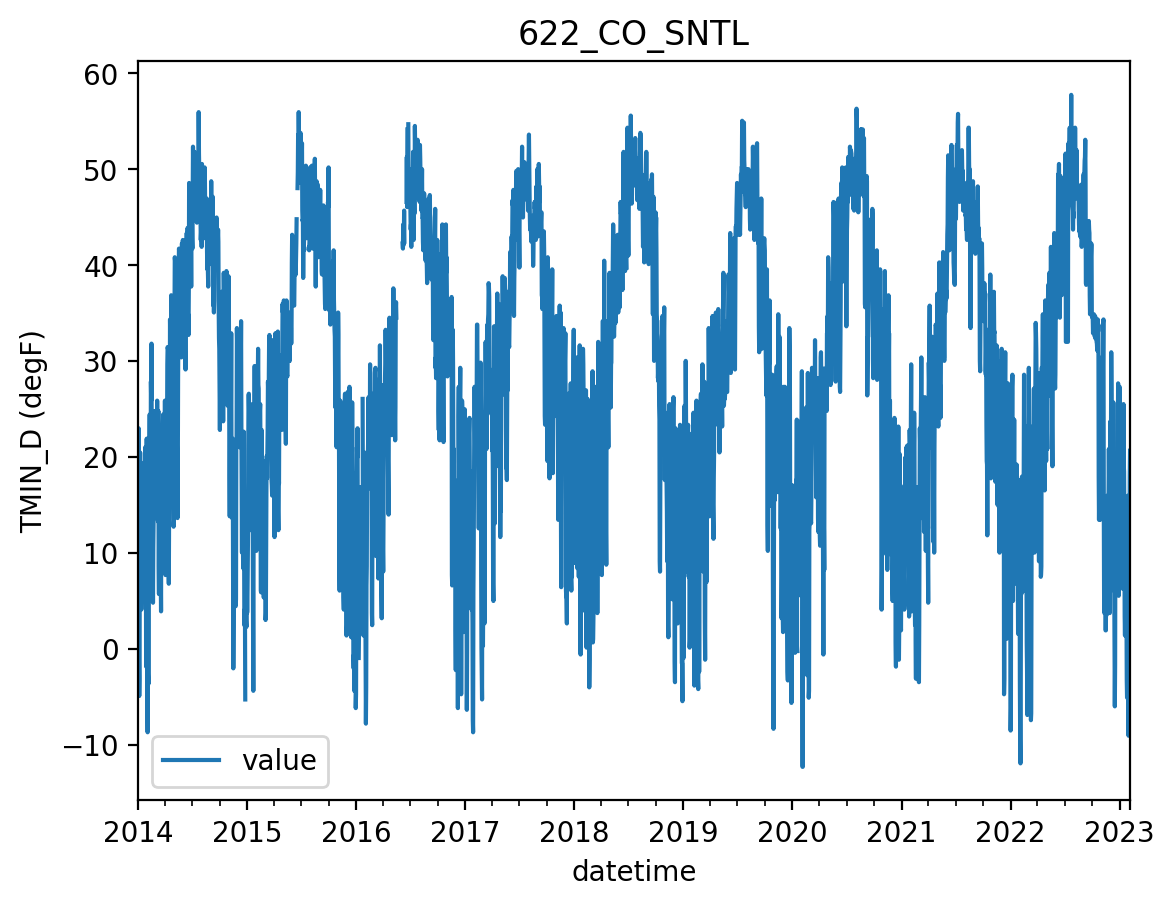

In [51]:
# Lots of intermittent failures it seems...
# URLError: <urlopen error [Errno -2] Name or service not known> gaierror
var = 'TMIN_D'
tmp = snotel_fetch(sitecode, variablecode=var, start_date='2014-01-01', end_date=datetime.today())
tmp['2014':].plot(y='value', title=sitecode, ylabel=var+' (degF)');

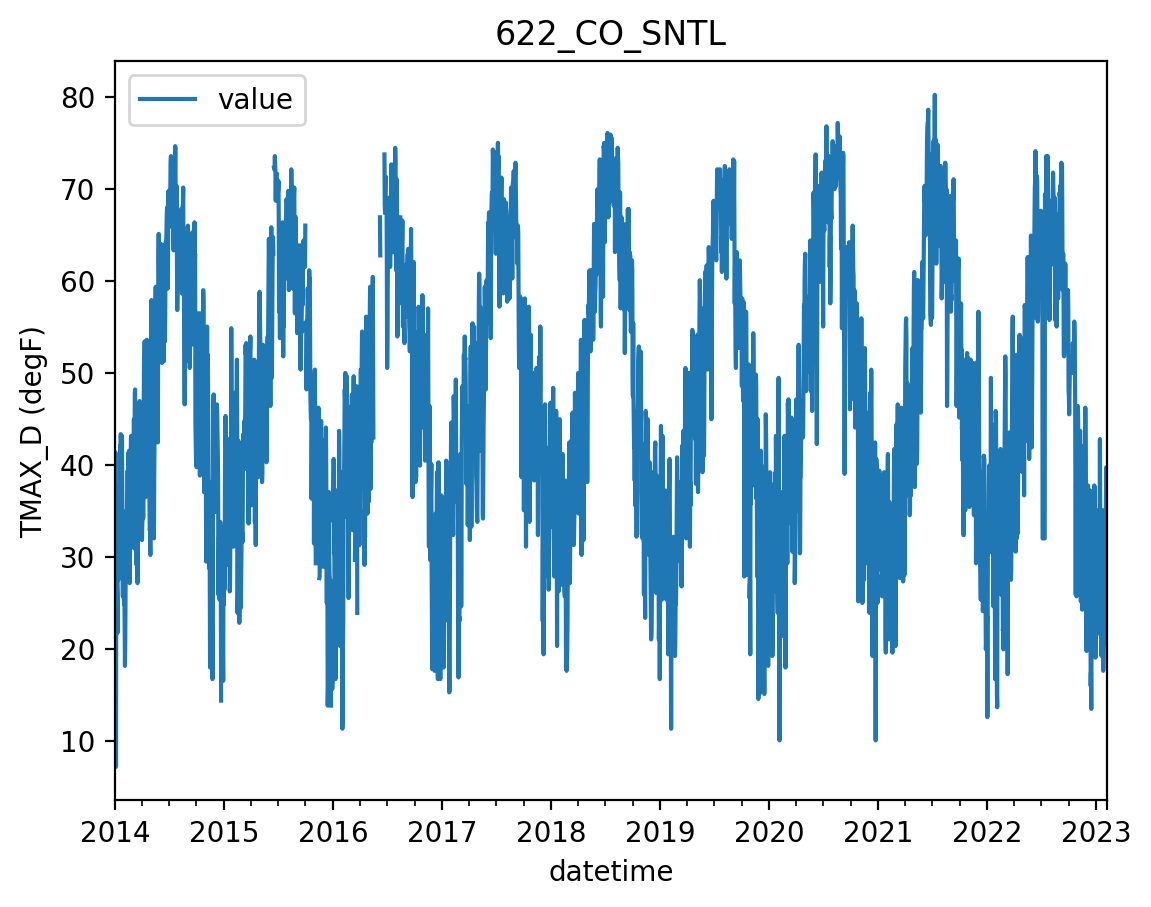

In [52]:
var = 'TMAX_D'
tmp = snotel_fetch(sitecode, variablecode=var, start_date='2014-01-01', end_date=datetime.today())
tmp['2014':].plot(y='value', title=sitecode, ylabel=var+' (degF)');

In [54]:
# Let's put the temp records into a single dataframe
def get_daily_temperatures(sitecode):
    ''' single dataframe with temperatures (C)'''
    df = snotel_fetch(sitecode, variablecode='SNOTEL:TAVG_D', start_date='2014-01-01', end_date=datetime.today())
    df = df.rename(columns={'value':'TAVG_D'})['TAVG_D'].to_frame()
    
    for var in ['TMIN_D','TMAX_D']: #,'TOBS_D']:
        tmp = snotel_fetch(sitecode, variablecode=f'SNOTEL:{var}', start_date='2014-01-01', end_date=datetime.today())
        tmp = tmp.rename(columns={'value':var})[var]
        df = df.join(tmp)
        
    # F to Celsius
    df = (df - 32) * 5/9
    
    return df


df = get_daily_temperatures(sitecode)

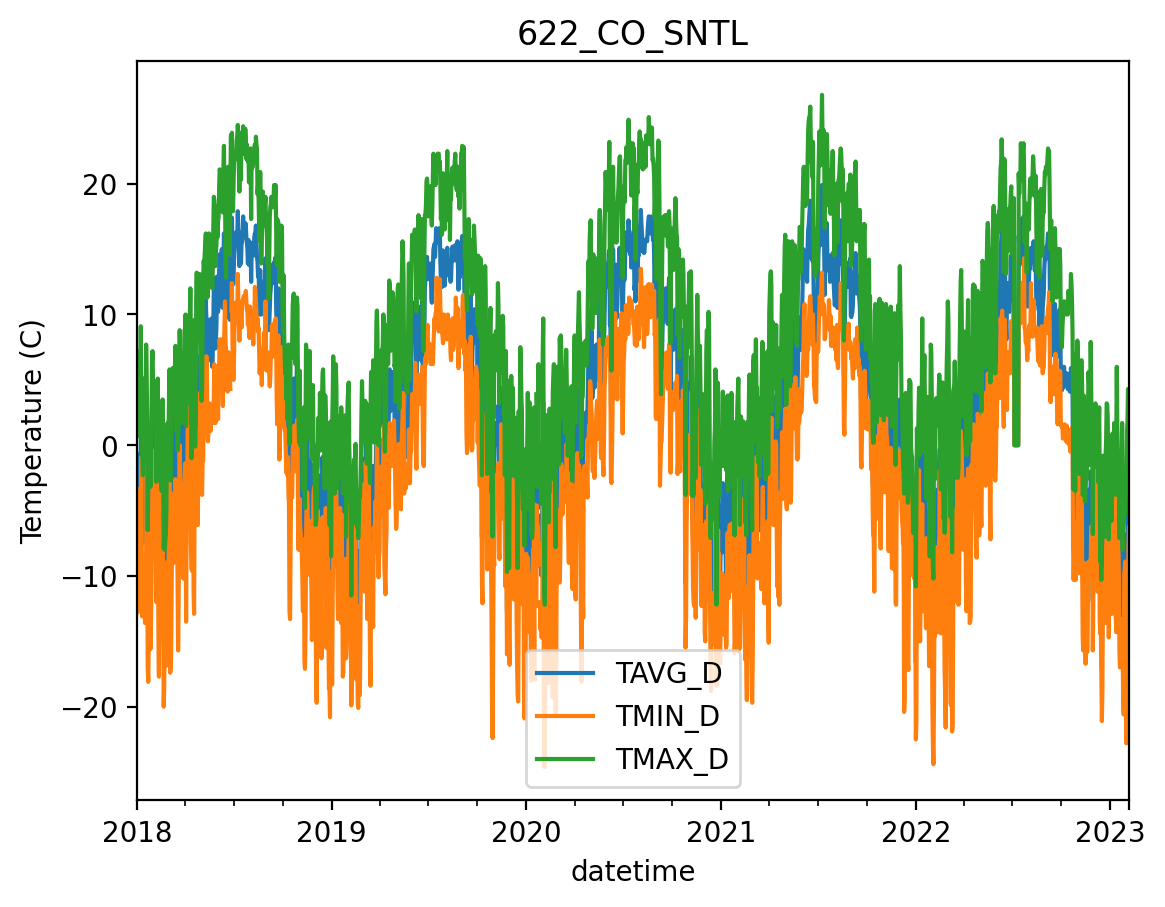

In [55]:
df['2018':].plot(title=sitecode, ylabel='Temperature (C)'); #both in in

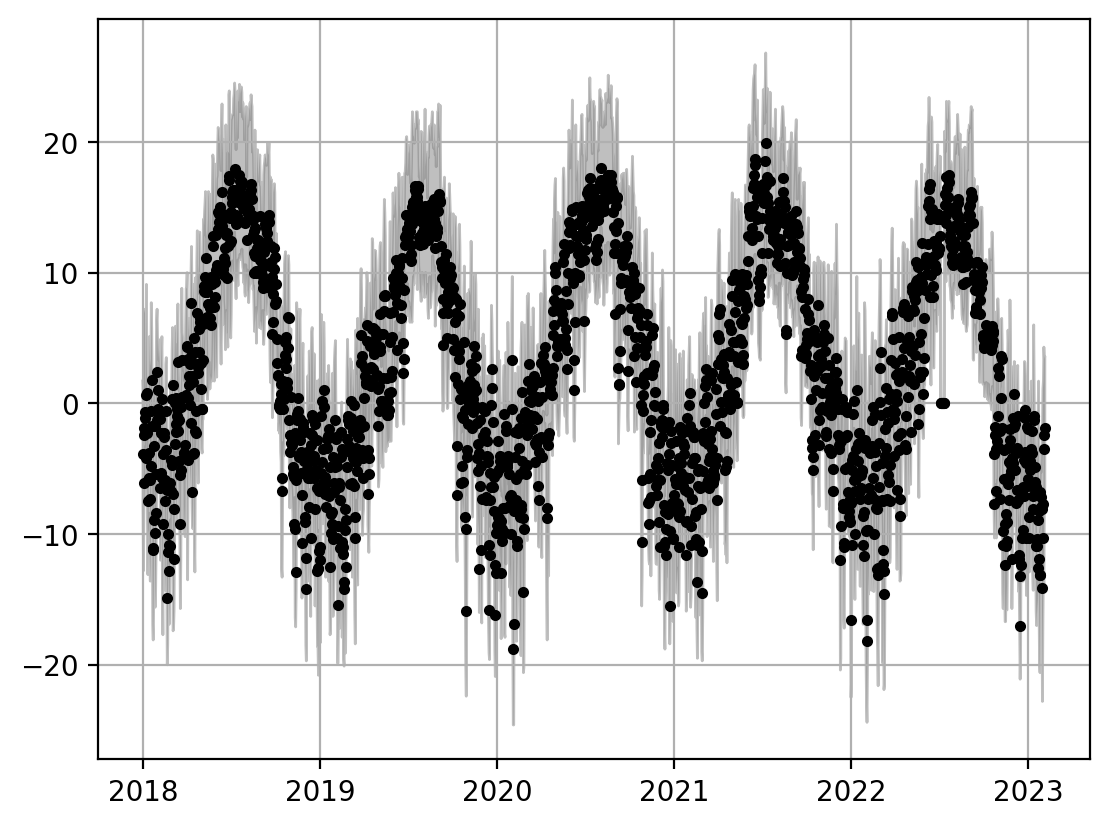

In [56]:
fig, ax = plt.subplots()

ax.fill_between(df['2018':].index.values, df['2018':].TMIN_D, df['2018':].TMAX_D, color='gray', alpha=0.5)
ax.plot(df['2018':].index.values, df['2018':].TAVG_D, 'k.');
ax.grid(True)
#ax.plot(df['2018':].index.values, df['2018':].TOBS_D, 'c.'); #Not sure about these

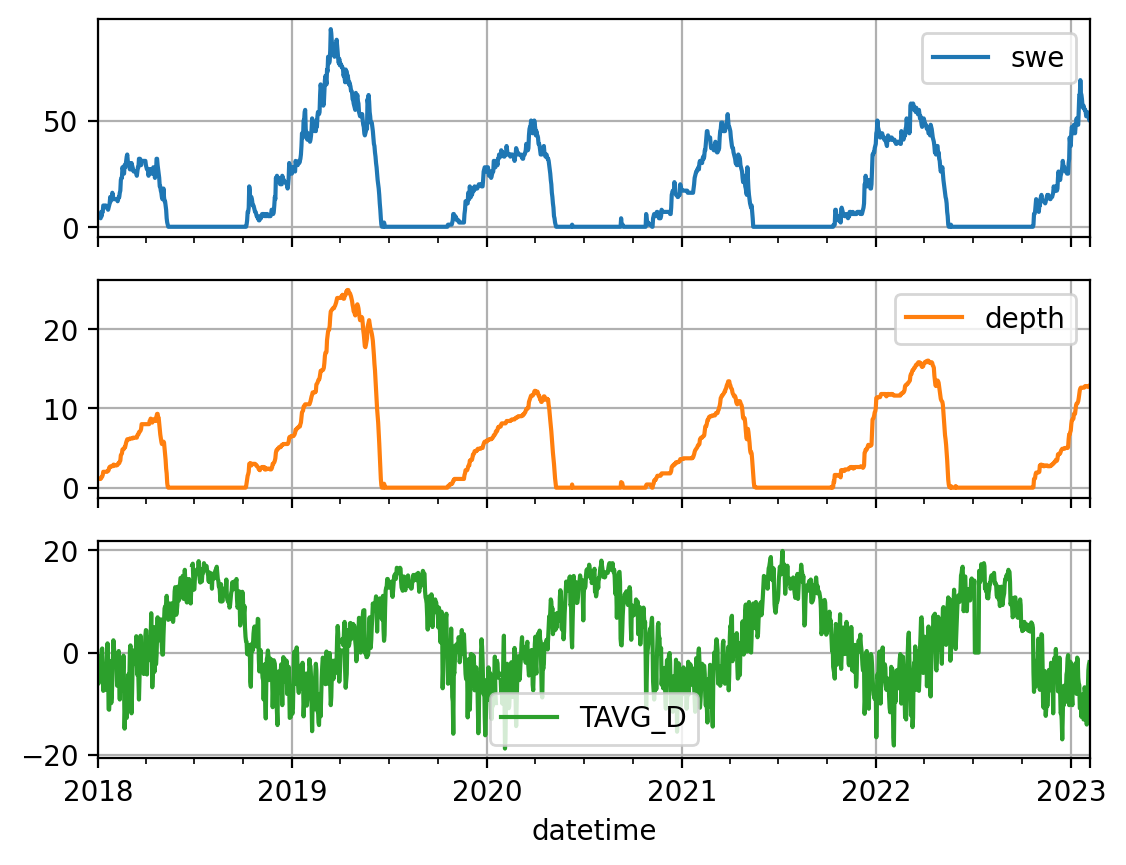

In [58]:
# NOTE: compare to something like daymet temperatures?
dfc.join(df.TAVG_D)['2018':].plot(subplots=True, grid=True);

In [107]:
def get_daily_vars(sitecode):
    station_info = ulmo.cuahsi.wof.get_site_info(wsdlurl, 'SNOTEL:'+sitecode)['series']
    daily_vars = [x for x in station_info.keys() if x.endswith('_D')]
    print(sitecode, len(daily_vars))
    print(daily_vars)
    #return len(daily_vars)
    
#gf.index.map(get_daily_vars) # slow, but returns useful info:
# 301_CA_SNTL 8
# 907_UT_SNTL 8
# 916_MT_SNTL 8
# 1267_AK_SNTL 9
# 908_WA_SNTL 8
# 1189_AK_SNTL 9
# 1062_AK_SNTL 9
# 1070_AK_SNTL 13
# 302_OR_SNTL 8
# 1000_OR_SNTL 8
# 303_CO_SNTL 8
# 1030_CO_SNTL 11
# 304_OR_SNTL 8
#get_daily_vars('1267_AK_SNTL') # SNOTEL:PRES_D # Barometric pressure?
#get_daily_vars('1070_AK_SNTL') #'SNOTEL:WDIRV_D', 'SNOTEL:WSPDV_D', 'SNOTEL:WSPDX_D','SNOTEL:SRADV_D' 'SNOTEL:RHUM_D'
# https://www.nrcs.usda.gov/wps/portal/wcc/home/dataAccessHelp/faqs/snotelSensors/
# Warning SLOW (900*2s = 1800s/60 = ~30min :( 
#nvars = [get_daily_vars(x) for x in gf.index.values]
#get_daily_vars('1030_CO_SNTL')  # SNOTEL:BATX_D
gf.head() # use HUC for unique identifier
station_info = ulmo.cuahsi.wof.get_site_info(wsdlurl, 'SNOTEL:'+'1030_CO_SNTL')['series']

,name,elevation_m,latitude,longitude,county,state,beginDate,endDate,isActive,geometry
code,,,,,,,,,,
301_CA_SNTL,Adin Mtn,1886.712036,41.235828,-120.791924,Modoc,California,1983-10-01,2100-01-01,True,POINT (-120.79192 41.23583)
907_UT_SNTL,Agua Canyon,2712.719971,37.522171,-112.271179,Kane,Utah,1994-10-01,2100-01-01,True,POINT (-112.27118 37.52217)
916_MT_SNTL,Albro Lake,2529.840088,45.597229,-111.959023,Madison,Montana,1996-09-01,2100-01-01,True,POINT (-111.95902 45.59723)
1267_AK_SNTL,Alexander Lake,48.768002,61.749668,-150.889664,Matanuska-Susitna,Alaska,2014-08-28,2100-01-01,True,POINT (-150.88966 61.74967)
908_WA_SNTL,Alpine Meadows,1066.800049,47.779572,-121.698471,King,Washington,1994-09-01,2100-01-01,True,POINT (-121.69847 47.77957)


In [ ]:
gf['nvars'] = nvars

In [110]:
gf[gf.index.str.startswith('907')]
station_info = ulmo.cuahsi.wof.get_site_info(wsdlurl, 'SNOTEL:'+'1030_CO_SNTL')['series']
daily_vars = [x for x in station_info.keys() if x.endswith('_D')]
len(daily_vars)

11

In [113]:
station_info.keys()

dict_keys(['SNOTEL:BATT_D', 'SNOTEL:BATT_H', 'SNOTEL:BATX_D', 'SNOTEL:PRCP_y', 'SNOTEL:PRCP_sm', 'SNOTEL:PRCP_m', 'SNOTEL:PRCP_wy', 'SNOTEL:PRCPSA_y', 'SNOTEL:PRCPSA_D', 'SNOTEL:PRCPSA_sm', 'SNOTEL:PRCPSA_m', 'SNOTEL:PRCPSA_wy', 'SNOTEL:PREC_sm', 'SNOTEL:PREC_m', 'SNOTEL:PREC_wy', 'SNOTEL:RHUM_D', 'SNOTEL:RHUM_H', 'SNOTEL:RHUMN_H', 'SNOTEL:RHUMV_H', 'SNOTEL:RHUMX_H', 'SNOTEL:SNWD_D', 'SNOTEL:SNWD_sm', 'SNOTEL:SNWD_H', 'SNOTEL:SNWD_m', 'SNOTEL:SRAD_D', 'SNOTEL:SRAD_H', 'SNOTEL:SRADV_H', 'SNOTEL:SRADX_H', 'SNOTEL:TAVG_y', 'SNOTEL:TAVG_D', 'SNOTEL:TAVG_sm', 'SNOTEL:TAVG_m', 'SNOTEL:TAVG_wy', 'SNOTEL:TMAX_y', 'SNOTEL:TMAX_D', 'SNOTEL:TMAX_sm', 'SNOTEL:TMAX_m', 'SNOTEL:TMAX_wy', 'SNOTEL:TMIN_y', 'SNOTEL:TMIN_D', 'SNOTEL:TMIN_sm', 'SNOTEL:TMIN_m', 'SNOTEL:TMIN_wy', 'SNOTEL:TOBS_D', 'SNOTEL:TOBS_sm', 'SNOTEL:TOBS_H', 'SNOTEL:TOBS_m', 'SNOTEL:WDIRV_H', 'SNOTEL:WSPDV_H', 'SNOTEL:WSPDX_H', 'SNOTEL:WTEQ_D', 'SNOTEL:WTEQ_sm', 'SNOTEL:WTEQ_H', 'SNOTEL:WTEQ_m'])

In [ ]:
gf.head()

In [117]:
station_info = ulmo.cuahsi.wof.get_site_info(wsdlurl, 'SNOTEL:'+'1267_AK_SNTL')['series']

In [120]:
# NOTE: also some empty

# station_info['SNOTEL:RHUM_D'] # 'Relative humidity' (%) # 'SNOTEL:RHUMN_D', 'SNOTEL:RHUMV_D', 'SNOTEL:RHUMX_D ?
# station_info['SNOTEL:SRADV_D'] #radiation watts (W/m^2)
# station_info['SNOTEL:WDIRV_D'] #Wind direction (deg)
# station_info['SNOTEL:WSPDX_D'] #Wind direction (miles per hour) 1mph = 0.44704 m/s
# station_info['SNOTEL:WSPDV_D'] #Wind direction (miles per hour)
# station_info['SNOTEL:PRES_D'] # 'Barometric Pressure' ('inch Hg')
# station_info['SNOTEL:BATX_D'] # 'Battery voltage' (V)
# station_info['SNOTEL:BATT_D']  #Battery voltage?... not sure of difference
# NOTE: not sure how to get soil moisture profiles, apparently some newer stations like 1030_CO_SNTL have it...

In [182]:
# Simply save a parquet timeseries with all values
def construct_daily_dataframe(sitecode, start='2014-01-01', end='2023-01-01'):
    '''write out parquet of all daily measurements'''
    station_info = ulmo.cuahsi.wof.get_site_info(wsdlurl, 'SNOTEL:'+sitecode)['series']
    daily_vars = [x for x in station_info.keys() if x.endswith('_D')]
    
    
    # # convert inches to meters
    df = snotel_fetch(sitecode, variablecode='TAVG_D', start_date=start, end_date=end)
    name = 'TAVG'
    df = df.rename(columns={'value':name})[name].to_frame()
    
    for var in ['TMIN_D','TMAX_D']: #,'TOBS_D']:
        tmp = snotel_fetch(sitecode, variablecode=var, start_date=start, end_date=end)
        name = var[:-2]
        tmp = tmp.rename(columns={'value':name})[name]
        df = df.join(tmp)
    
    # Convert F to Celsius
    df = (df - 32) * 5/9
    
    # Add snowdepth and precip (all inches
    for var in ['SNWD_D','WTEQ_D','PRCPSA_D']: 
        tmp = snotel_fetch(sitecode, variablecode=var, start_date=start, end_date=end)
        name = var[:-2]
        tmp = tmp.rename(columns={'value':name})[name]
        tmp /= 39.3701
        df = df.join(tmp)

    # Drop UTC timestamp since all 0, and add freq='D'
    df.index = df.index.tz_localize(None).normalize()
    return df.astype('float32')

In [177]:
%%time
sitecode = gf.index[0]
df = construct_daily_dataframe(sitecode)

CPU times: user 2.02 s, sys: 8.36 ms, total: 2.03 s
Wall time: 13 s


In [178]:
df.head()

,TAVG,TMIN,TMAX,SNWD,WTEQ,PRCPSA
datetime,,,,,,
2014-01-01,0.2,-6.7,10.6,0.0254,0.01270,0.00254
2014-01-02,0.3,-5.7,12.7,0.0508,0.01524,0.00000
2014-01-03,1.8,-4.6,9.5,0.0508,0.01270,0.00254
2014-01-04,-2.0,-9.0,5.6,0.0508,0.01524,0.00000
2014-01-05,-0.6,-10.2,7.1,0.0508,0.01524,0.00000


In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2014-01-01 to 2023-01-01
Freq: D
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TAVG    3284 non-null   float32
 1   TMIN    3284 non-null   float32
 2   TMAX    3284 non-null   float32
 3   SNWD    3286 non-null   float32
 4   WTEQ    3287 non-null   float32
 5   PRCPSA  3276 non-null   float32
dtypes: float32(6)
memory usage: 102.8 KB


In [180]:
df.to_parquet('timeseries/'+sitecode+'.parquet')

In [181]:
ls -lh timeseries/301_CA_SNTL.parquet

-rw-r--r-- 1 jovyan users 53K Feb  7 01:35 timeseries/301_CA_SNTL.parquet


In [184]:
%%time

# slow but functional
# Error catch: WebFault: Server raised fault: 'Object reference not set to an instance of an object.'
for station in gf.index:
    print(station)
    output = 'timeseries/'+station+'.parquet'
    if not os.path.exists(output):
        print('saving timeseries...')
        try:
            df = construct_daily_dataframe(station)
            df.to_parquet(output)
        except:
            print('ERROR')

301_CA_SNTL
907_UT_SNTL
916_MT_SNTL
1267_AK_SNTL
908_WA_SNTL
1189_AK_SNTL
1062_AK_SNTL
1070_AK_SNTL
302_OR_SNTL
1000_OR_SNTL
303_CO_SNTL
1030_CO_SNTL
304_OR_SNTL
305_CO_SNTL
saving timeseries...


ERROR
957_AK_SNTL
saving timeseries...


ERROR
306_ID_SNTL
saving timeseries...
8082_UT_SNTL
saving timeseries...


ERROR
307_MT_SNTL
saving timeseries...
308_AZ_SNTL
saving timeseries...
1140_AZ_SNTL
saving timeseries...
309_WY_SNTL
saving timeseries...
310_AZ_SNTL
saving timeseries...
311_MT_SNTL
saving timeseries...
312_ID_SNTL
saving timeseries...
1212_AZ_SNTL
saving timeseries...
313_MT_SNTL
saving timeseries...
314_WY_SNTL
saving timeseries...
315_MT_SNTL
saving timeseries...
316_NM_SNTL
saving timeseries...
317_WY_SNTL
saving timeseries...
318_MT_SNTL
saving timeseries...
319_ID_SNTL
saving timeseries...
320_ID_SNTL
saving timeseries...
321_NV_SNTL
saving timeseries...
1166_OR_SNTL
saving timeseries...
322_CO_SNTL
saving timeseries...
323_ID_SNTL
saving timeseries...
1061_CO_SNTL
saving timeseries...
992_UT_SNTL
saving timeseries...
324_ID_SNTL
saving timeseries...
325_WY_SNTL
saving timeseries...
326_WY_SNTL
saving timeseries...
327_CO_SNTL
saving timeseries...
1041_CO_SNTL
saving timeseries...
328_MT_SNTL
saving timeseries...
329_UT_SNTL
saving timeseries...
330_UT_SNTL
saving timeseries...

ERROR
1086_AK_SNTL
saving timeseries...


ERROR
334_NV_SNTL
saving timeseries...
335_CO_SNTL
saving timeseries...
1182_AK_SNTL
saving timeseries...
1214_UT_SNTL
saving timeseries...
336_NV_SNTL
saving timeseries...
337_NV_SNTL
saving timeseries...
338_ID_SNTL
saving timeseries...
339_UT_SNTL
saving timeseries...
931_WY_SNTL
saving timeseries...
340_NV_SNTL
saving timeseries...
341_OR_SNTL
saving timeseries...
342_WY_SNTL
saving timeseries...
343_OR_SNTL
saving timeseries...
344_OR_SNTL
saving timeseries...
1155_NV_SNTL
saving timeseries...
345_CO_SNTL
saving timeseries...
346_MT_SNTL
saving timeseries...
347_MT_SNTL
saving timeseries...
348_UT_SNTL
saving timeseries...
1185_CO_SNTL
saving timeseries...
1161_CO_SNTL
saving timeseries...
349_MT_SNTL
saving timeseries...
1119_WY_SNTL
saving timeseries...
1162_UT_SNTL
saving timeseries...
1144_MT_SNTL
saving timeseries...
350_WY_SNTL
saving timeseries...
351_OR_SNTL
saving timeseries...
352_WA_SNTL
saving timeseries...
353_WY_SNTL
saving timeseries...
354_SD_SNTL
saving timeseries

ERROR
366_UT_SNTL
saving timeseries...
1111_NV_SNTL
saving timeseries...
367_WY_SNTL
saving timeseries...
368_UT_SNTL
saving timeseries...
1080_WA_SNTL
saving timeseries...
369_CO_SNTL
saving timeseries...
370_ID_SNTL
saving timeseries...
371_UT_SNTL
saving timeseries...
1192_UT_SNTL
saving timeseries...
372_AZ_SNTL
saving timeseries...


ERROR
1153_UT_SNTL
saving timeseries...
1107_WA_SNTL
saving timeseries...
938_CO_SNTL
saving timeseries...
373_NV_SNTL
saving timeseries...
913_CO_SNTL
saving timeseries...
374_UT_SNTL
saving timeseries...
375_WA_SNTL
saving timeseries...
376_WA_SNTL
saving timeseries...
377_WY_SNTL
saving timeseries...
1051_CA_SNTL
saving timeseries...
942_WA_SNTL
saving timeseries...
981_MT_SNTL
saving timeseries...
378_CO_SNTL
saving timeseries...
379_WY_SNTL
saving timeseries...
1135_UT_SNTL
saving timeseries...
380_CO_SNTL
saving timeseries...
1109_WA_SNTL
saving timeseries...
381_MT_SNTL
saving timeseries...
382_ID_SNTL
saving timeseries...
383_UT_SNTL
saving timeseries...
384_WY_SNTL
saving timeseries...
385_MT_SNTL
saving timeseries...
1067_CA_SNTL
saving timeseries...
386_CO_SNTL
saving timeseries...
387_CO_SNTL
saving timeseries...
1039_UT_SNTL
saving timeseries...
388_OR_SNTL
saving timeseries...
253_MT_SNTL
saving timeseries...


ERROR
389_WY_SNTL
saving timeseries...
1130_WY_SNTL
saving timeseries...
390_UT_SNTL
saving timeseries...
247_CO_SNTL
saving timeseries...


ERROR
1152_NV_SNTL
saving timeseries...
1085_WA_SNTL
saving timeseries...
391_CA_SNTL
saving timeseries...
1139_AZ_SNTL
saving timeseries...
392_UT_SNTL
saving timeseries...
393_UT_SNTL
saving timeseries...
394_NM_SNTL
saving timeseries...
1101_CO_SNTL
saving timeseries...
395_OR_SNTL
saving timeseries...
396_UT_SNTL
saving timeseries...
1093_AK_SNTL
saving timeseries...
895_ID_SNTL
saving timeseries...
397_WY_SNTL
saving timeseries...


ERROR
1046_WY_SNTL
saving timeseries...
398_OR_SNTL
saving timeseries...
983_UT_SNTL
saving timeseries...
399_UT_SNTL
saving timeseries...
400_UT_SNTL
saving timeseries...
401_OR_SNTL
saving timeseries...
402_WY_SNTL
saving timeseries...
403_MT_SNTL
saving timeseries...
1059_CO_SNTL
saving timeseries...
405_WY_SNTL
saving timeseries...
406_OR_SNTL
saving timeseries...
958_AK_SNTL
saving timeseries...
982_WY_SNTL
saving timeseries...
407_MT_SNTL
saving timeseries...
1204_NV_SNTL
saving timeseries...


ERROR
408_CO_SNTL
saving timeseries...
409_CO_SNTL
saving timeseries...
904_CO_SNTL
saving timeseries...
410_MT_SNTL
saving timeseries...
411_ID_SNTL
saving timeseries...
959_AK_SNTL
saving timeseries...
412_CO_SNTL
saving timeseries...
413_MT_SNTL
saving timeseries...
414_MT_SNTL
saving timeseries...
415_CO_SNTL
saving timeseries...
1209_NV_SNTL
saving timeseries...


ERROR
416_AZ_SNTL
saving timeseries...
1236_UT_SNTL
saving timeseries...
417_NV_SNTL
saving timeseries...
418_WA_SNTL
saving timeseries...
419_WY_SNTL
saving timeseries...
420_WA_SNTL
saving timeseries...
421_WY_SNTL
saving timeseries...


ERROR
422_OR_SNTL
saving timeseries...
423_ID_SNTL
saving timeseries...
424_ID_SNTL
saving timeseries...
425_ID_SNTL
saving timeseries...
1010_OR_SNTL
saving timeseries...
426_CO_SNTL
saving timeseries...
1045_WY_SNTL
saving timeseries...
977_CA_SNTL
saving timeseries...
427_MT_SNTL
saving timeseries...
428_CA_SNTL
saving timeseries...
430_CO_SNTL
saving timeseries...
431_CO_SNTL
saving timeseries...
432_UT_SNTL
saving timeseries...
919_MT_SNTL
saving timeseries...
433_MT_SNTL
saving timeseries...
434_OR_SNTL
saving timeseries...
435_UT_SNTL
saving timeseries...
436_MT_SNTL
saving timeseries...
437_MT_SNTL
saving timeseries...
438_CO_SNTL
saving timeseries...
439_ID_SNTL
saving timeseries...
923_WY_SNTL
saving timeseries...
1210_NV_SNTL
saving timeseries...


ERROR
440_OR_SNTL
saving timeseries...
441_UT_SNTL
saving timeseries...


ERROR
442_OR_SNTL
saving timeseries...
443_NV_SNTL
saving timeseries...
444_UT_SNTL
saving timeseries...
8011_WY_SNTL
saving timeseries...


ERROR
445_NV_SNTL
saving timeseries...
446_CA_SNTL
saving timeseries...
448_MT_SNTL
saving timeseries...
449_WY_SNTL
saving timeseries...
450_ID_SNTL
saving timeseries...
451_WY_SNTL
saving timeseries...
452_UT_SNTL
saving timeseries...
453_NV_SNTL
saving timeseries...
454_NV_SNTL
saving timeseries...
455_UT_SNTL
saving timeseries...
1243_NV_SNTL
saving timeseries...
906_UT_SNTL
saving timeseries...
457_CO_SNTL
saving timeseries...
943_WA_SNTL
saving timeseries...
458_MT_SNTL
saving timeseries...
960_AK_SNTL
saving timeseries...


ERROR
1105_MT_SNTL
saving timeseries...
460_WY_SNTL
saving timeseries...
461_UT_SNTL
saving timeseries...
998_WA_SNTL
saving timeseries...
462_CA_SNTL
saving timeseries...
936_CO_SNTL
saving timeseries...
463_CA_SNTL
saving timeseries...
1163_UT_SNTL
saving timeseries...
464_OR_SNTL
saving timeseries...
465_CO_SNTL
saving timeseries...
910_WA_SNTL
saving timeseries...
466_ID_SNTL
saving timeseries...
921_NM_SNTL
saving timeseries...
1106_MT_SNTL
saving timeseries...
467_CO_SNTL
saving timeseries...
468_WY_SNTL
saving timeseries...
1252_CO_SNTL
saving timeseries...
1120_CO_SNTL
saving timeseries...
469_MT_SNTL
saving timeseries...
470_OR_SNTL
saving timeseries...
471_ID_SNTL
saving timeseries...
1027_OR_SNTL
saving timeseries...


ERROR
1026_OR_SNTL
saving timeseries...


ERROR
1028_OR_SNTL
saving timeseries...


ERROR
1022_OR_SNTL
saving timeseries...


ERROR
1023_OR_SNTL
saving timeseries...


ERROR
1029_OR_SNTL
saving timeseries...


ERROR
1021_OR_SNTL
saving timeseries...


ERROR
1020_OR_SNTL
saving timeseries...


ERROR
995_WA_SNTL
saving timeseries...


ERROR
994_WA_SNTL
saving timeseries...


ERROR
1019_OR_SNTL
saving timeseries...


ERROR
1018_OR_SNTL
saving timeseries...


ERROR
1025_OR_SNTL
saving timeseries...


ERROR
1024_OR_SNTL
saving timeseries...


ERROR
1004_WA_SNTL
saving timeseries...


ERROR
976_OR_SNTL
saving timeseries...


ERROR
1071_AK_SNTL
saving timeseries...


ERROR
472_WY_SNTL
saving timeseries...
1092_AK_SNTL
saving timeseries...
1174_AK_SNTL
saving timeseries...
473_CA_SNTL
saving timeseries...
474_UT_SNTL
saving timeseries...
1054_UT_SNTL
saving timeseries...
475_UT_SNTL
saving timeseries...
476_NV_SNTL
saving timeseries...
1268_AK_SNTL
saving timeseries...
477_OR_SNTL
saving timeseries...
478_WA_SNTL
saving timeseries...
1149_UT_SNTL
saving timeseries...
479_OR_SNTL
saving timeseries...
480_MT_SNTL
saving timeseries...
481_UT_SNTL
saving timeseries...
482_MT_SNTL
saving timeseries...
1285_AK_SNTL
saving timeseries...
1186_CO_SNTL
saving timeseries...
1049_CA_SNTL
saving timeseries...
1121_AZ_SNTL
saving timeseries...
961_AK_SNTL
saving timeseries...


ERROR
483_OR_SNTL
saving timeseries...
484_ID_SNTL
saving timeseries...
1277_CA_SNTL
saving timeseries...
485_CO_SNTL
saving timeseries...
486_NM_SNTL
saving timeseries...
487_MT_SNTL
saving timeseries...
488_AZ_SNTL
saving timeseries...
1262_NV_SNTL
saving timeseries...
489_ID_SNTL
saving timeseries...
490_ID_SNTL
saving timeseries...
491_NM_SNTL
saving timeseries...
1114_UT_SNTL
saving timeseries...
1066_UT_SNTL
saving timeseries...
492_ID_SNTL
saving timeseries...
1173_NM_SNTL
saving timeseries...
918_MT_SNTL
saving timeseries...
1221_UT_SNTL
saving timeseries...
1222_UT_SNTL
saving timeseries...
1151_UT_SNTL
saving timeseries...
945_OR_SNTL
saving timeseries...
493_ID_SNTL
saving timeseries...
1057_CO_SNTL
saving timeseries...
257_NV_SNTL
saving timeseries...


ERROR
962_AK_SNTL
saving timeseries...


ERROR
1195_NV_SNTL
saving timeseries...
1159_WA_SNTL
saving timeseries...
494_OR_SNTL
saving timeseries...
1256_WA_SNTL
saving timeseries...
495_UT_SNTL
saving timeseries...
1184_UT_SNTL
saving timeseries...
496_ID_SNTL
saving timeseries...
1082_WY_SNTL
saving timeseries...
956_AK_SNTL
saving timeseries...
497_WY_SNTL
saving timeseries...
963_AK_SNTL
saving timeseries...
498_NV_SNTL
saving timeseries...
499_WY_SNTL
saving timeseries...
500_MT_SNTL
saving timeseries...
501_WY_SNTL
saving timeseries...
1058_CO_SNTL
saving timeseries...
502_WA_SNTL
saving timeseries...
503_NV_SNTL
saving timeseries...
504_OR_SNTL
saving timeseries...
505_CO_SNTL
saving timeseries...
506_WY_SNTL
saving timeseries...
507_WA_SNTL
saving timeseries...
964_AK_SNTL
saving timeseries...
944_WY_SNTL
saving timeseries...
1065_UT_SNTL
saving timeseries...
508_CA_SNTL
saving timeseries...
248_CO_SNTL
saving timeseries...


ERROR
509_WY_SNTL
saving timeseries...
510_MT_SNTL
saving timeseries...
511_AZ_SNTL
saving timeseries...
512_WY_SNTL
saving timeseries...
969_AZ_SNTL
saving timeseries...
896_UT_SNTL
saving timeseries...
514_UT_SNTL
saving timeseries...
515_WA_SNTL
saving timeseries...
516_MT_SNTL
saving timeseries...
1271_AZ_SNTL
saving timeseries...
517_UT_SNTL
saving timeseries...
1102_CO_SNTL
saving timeseries...
518_CA_SNTL
saving timeseries...
519_AZ_SNTL
saving timeseries...
1270_AK_SNTL
saving timeseries...
520_ID_SNTL
saving timeseries...
521_UT_SNTL
saving timeseries...
522_UT_SNTL
saving timeseries...
988_ID_SNTL
saving timeseries...
1187_CO_SNTL
saving timeseries...
523_OR_SNTL
saving timeseries...
524_ID_SNTL
saving timeseries...
1223_UT_SNTL
saving timeseries...
525_WY_SNTL
saving timeseries...
526_OR_SNTL
saving timeseries...
527_NV_SNTL
saving timeseries...
528_UT_SNTL
saving timeseries...
529_OR_SNTL
saving timeseries...
530_MT_SNTL
saving timeseries...
531_CO_SNTL
saving timeseries...

ERROR
928_WA_SNTL
saving timeseries...
535_ID_SNTL
saving timeseries...
1216_UT_SNTL
saving timeseries...
259_OR_SNTL
saving timeseries...


ERROR
537_ID_SNTL
saving timeseries...
538_CO_SNTL
saving timeseries...
968_AK_SNTL
saving timeseries...


ERROR
539_CA_SNTL
saving timeseries...
540_CA_SNTL
saving timeseries...
541_CA_SNTL
saving timeseries...
1091_AK_SNTL
saving timeseries...
542_CO_SNTL
saving timeseries...
543_UT_SNTL
saving timeseries...
544_WY_SNTL
saving timeseries...
946_AK_SNTL
saving timeseries...
1129_WA_SNTL
saving timeseries...
266_WY_SNTL
saving timeseries...


ERROR
545_OR_SNTL
saving timeseries...
1276_ID_SNTL
saving timeseries...


ERROR
546_ID_SNTL
saving timeseries...
547_CO_SNTL
saving timeseries...
548_NV_SNTL
saving timeseries...
1275_AK_SNTL
saving timeseries...
549_NV_SNTL
saving timeseries...
550_ID_SNTL
saving timeseries...
935_CO_SNTL
saving timeseries...
1211_NV_SNTL
saving timeseries...


ERROR
551_CO_SNTL
saving timeseries...
1036_AK_SNTL
saving timeseries...


ERROR
1099_UT_SNTL
saving timeseries...
970_CO_SNTL
saving timeseries...
552_OR_SNTL
saving timeseries...
553_WA_SNTL
saving timeseries...
1063_AK_SNTL
saving timeseries...


ERROR
1150_NV_SNTL
saving timeseries...
1072_AK_SNTL
saving timeseries...
554_WY_SNTL
saving timeseries...
1175_AK_SNTL
saving timeseries...
966_AK_SNTL
saving timeseries...
555_WY_SNTL
saving timeseries...
1145_UT_SNTL
saving timeseries...
556_CO_SNTL
saving timeseries...
557_UT_SNTL
saving timeseries...
558_OR_SNTL
saving timeseries...
559_UT_SNTL
saving timeseries...
560_WY_SNTL
saving timeseries...
1115_UT_SNTL
saving timeseries...
201_AK_SNTL
saving timeseries...


ERROR
561_UT_SNTL
saving timeseries...
562_MT_SNTL
saving timeseries...
563_OR_SNTL
saving timeseries...
564_CO_SNTL
saving timeseries...
565_CO_SNTL
saving timeseries...
566_UT_SNTL
saving timeseries...
1116_UT_SNTL
saving timeseries...
513_UT_SNTL
saving timeseries...
568_MT_SNTL
saving timeseries...
569_NV_SNTL
saving timeseries...
570_NV_SNTL
saving timeseries...
571_WY_SNTL
saving timeseries...
1134_WY_SNTL
saving timeseries...
572_UT_SNTL
saving timeseries...
1215_UT_SNTL
saving timeseries...
573_NV_SNTL
saving timeseries...
574_CA_SNTL
saving timeseries...
575_CA_SNTL
saving timeseries...
1112_NV_SNTL
saving timeseries...
576_MT_SNTL
saving timeseries...
577_WY_SNTL
saving timeseries...
1006_NV_SNTL
saving timeseries...
578_MT_SNTL
saving timeseries...
261_UT_SNTL
saving timeseries...


ERROR
1056_UT_SNTL
saving timeseries...
579_UT_SNTL
saving timeseries...
580_CO_SNTL
saving timeseries...
582_UT_SNTL
saving timeseries...
947_AK_SNTL
saving timeseries...
1131_WY_SNTL
saving timeseries...
583_UT_SNTL
saving timeseries...
584_OR_SNTL
saving timeseries...
1047_WY_SNTL
saving timeseries...
1242_NV_SNTL
saving timeseries...
585_WY_SNTL
saving timeseries...
586_CO_SNTL
saving timeseries...
587_CA_SNTL
saving timeseries...
588_ID_SNTL
saving timeseries...
589_CO_SNTL
saving timeseries...
590_MT_SNTL
saving timeseries...
591_WA_SNTL
saving timeseries...
1261_UT_SNTL
saving timeseries...
1123_CO_SNTL
saving timeseries...
592_UT_SNTL
saving timeseries...
1001_AK_SNTL
saving timeseries...
1016_ID_SNTL
saving timeseries...
593_UT_SNTL
saving timeseries...
594_ID_SNTL
saving timeseries...
595_NM_SNTL
saving timeseries...
596_UT_SNTL
saving timeseries...
597_WY_SNTL
saving timeseries...
598_WY_SNTL
saving timeseries...


ERROR
1118_UT_SNTL
saving timeseries...
940_CO_SNTL
saving timeseries...
599_WA_SNTL
saving timeseries...
600_ID_SNTL
saving timeseries...
601_ID_SNTL
saving timeseries...
972_UT_SNTL
saving timeseries...
602_CO_SNTL
saving timeseries...
1265_AK_SNTL
saving timeseries...


ERROR
603_MT_SNTL
saving timeseries...
604_MT_SNTL
saving timeseries...
605_OR_SNTL
saving timeseries...
606_WA_SNTL
saving timeseries...
1069_WA_SNTL
saving timeseries...
607_CO_SNTL
saving timeseries...
608_OR_SNTL
saving timeseries...
609_MT_SNTL
saving timeseries...
610_ID_SNTL
saving timeseries...
611_SD_SNTL
saving timeseries...


ERROR
612_UT_SNTL
saving timeseries...
905_CO_SNTL
saving timeseries...
613_MT_SNTL
saving timeseries...
614_OR_SNTL
saving timeseries...
615_NV_SNTL
saving timeseries...
616_WY_SNTL
saving timeseries...
999_WA_SNTL
saving timeseries...
617_AZ_SNTL
saving timeseries...
1096_AK_SNTL
saving timeseries...
254_MT_SNTL
saving timeseries...


ERROR
618_CO_SNTL
saving timeseries...
1040_CO_SNTL
saving timeseries...
619_OR_SNTL
saving timeseries...
1048_NM_SNTL
saving timeseries...
1003_AK_SNTL
saving timeseries...
1191_AK_SNTL
saving timeseries...


ERROR
620_ID_SNTL
saving timeseries...
897_WA_SNTL
saving timeseries...
1196_WY_SNTL
saving timeseries...
914_CO_SNTL
saving timeseries...
621_UT_SNTL
saving timeseries...
1207_NV_SNTL
saving timeseries...
622_CO_SNTL
saving timeseries...
1011_WA_SNTL
saving timeseries...
623_ID_SNTL
saving timeseries...
937_CO_SNTL
saving timeseries...
1206_NV_SNTL
saving timeseries...


ERROR
624_CO_SNTL
saving timeseries...
1064_AK_SNTL
saving timeseries...


ERROR
1014_CO_SNTL
saving timeseries...
625_WY_SNTL
saving timeseries...
626_UT_SNTL
saving timeseries...
1079_OR_SNTL
saving timeseries...
627_ID_SNTL
saving timeseries...
628_UT_SNTL
saving timeseries...
1084_OR_SNTL
saving timeseries...
629_CO_SNTL
saving timeseries...
630_WA_SNTL
saving timeseries...


ERROR
631_UT_SNTL
saving timeseries...
262_WA_SNTL
saving timeseries...


ERROR
632_CO_SNTL
saving timeseries...
1287_MT_SNTL
saving timeseries...
1094_AK_SNTL
saving timeseries...
633_CA_SNTL
saving timeseries...
634_UT_SNTL
saving timeseries...
949_AK_SNTL
saving timeseries...
635_MT_SNTL
saving timeseries...
1124_CO_SNTL
saving timeseries...
636_ID_SNTL
saving timeseries...
1176_AK_SNTL
saving timeseries...


ERROR
638_ID_SNTL
saving timeseries...
1035_AK_SNTL
saving timeseries...
637_ID_SNTL
saving timeseries...
639_ID_SNTL
saving timeseries...
640_AZ_SNTL
saving timeseries...
1125_AZ_SNTL
saving timeseries...
642_WA_SNTL
saving timeseries...
643_UT_SNTL
saving timeseries...
989_ID_SNTL
saving timeseries...
644_WA_SNTL
saving timeseries...
645_ID_SNTL
saving timeseries...
646_MT_SNTL
saving timeseries...
647_OR_SNTL
saving timeseries...
648_WA_SNTL
saving timeseries...
898_WA_SNTL
saving timeseries...
649_MT_SNTL
saving timeseries...
650_ID_SNTL
saving timeseries...
941_WA_SNTL
saving timeseries...
1224_UT_SNTL
saving timeseries...
651_OR_SNTL
saving timeseries...
1269_UT_SNTL
saving timeseries...
652_NV_SNTL
saving timeseries...
1103_AK_SNTL
saving timeseries...
1073_AK_SNTL
saving timeseries...
653_OR_SNTL
saving timeseries...
258_NV_SNTL
saving timeseries...


ERROR
948_AK_SNTL
saving timeseries...
1259_WA_SNTL
saving timeseries...
654_ID_SNTL
saving timeseries...
655_OR_SNTL
saving timeseries...
656_MT_SNTL
saving timeseries...
950_AK_SNTL
saving timeseries...
1053_ID_SNTL
saving timeseries...
657_MT_SNTL
saving timeseries...
658_CO_SNTL
saving timeseries...
1138_NM_SNTL
saving timeseries...
249_CO_SNTL
saving timeseries...


ERROR
659_MT_SNTL
saving timeseries...


ERROR
903_MT_SNTL
saving timeseries...
1031_CO_SNTL
saving timeseries...
660_OR_SNTL
saving timeseries...
661_WY_SNTL
saving timeseries...
662_MT_SNTL
saving timeseries...
663_CO_SNTL
saving timeseries...
664_MT_SNTL
saving timeseries...
665_NM_SNTL
saving timeseries...
666_OR_SNTL
saving timeseries...
667_MT_SNTL
saving timeseries...
668_WY_SNTL
saving timeseries...
669_CO_SNTL
saving timeseries...
920_SD_SNTL
saving timeseries...
670_MT_SNTL
saving timeseries...
267_WY_SNTL
saving timeseries...


ERROR
1037_AK_SNTL
saving timeseries...


ERROR
1127_AZ_SNTL
saving timeseries...
996_WA_SNTL
saving timeseries...


ERROR
1146_UT_SNTL
saving timeseries...
671_OR_SNTL
saving timeseries...
672_WA_SNTL
saving timeseries...
673_WY_SNTL
saving timeseries...
1272_NV_SNTL
saving timeseries...
1008_MT_SNTL
saving timeseries...
675_CO_SNTL
saving timeseries...
676_WY_SNTL
saving timeseries...
677_ID_SNTL
saving timeseries...
1170_NM_SNTL
saving timeseries...
678_NM_SNTL
saving timeseries...


ERROR
1148_UT_SNTL
saving timeseries...
679_WA_SNTL
saving timeseries...
986_AK_SNTL
saving timeseries...


ERROR
680_CO_SNTL
saving timeseries...
681_WA_SNTL
saving timeseries...
682_CO_SNTL
saving timeseries...
683_WY_SNTL
saving timeseries...
684_UT_SNTL
saving timeseries...
971_UT_SNTL
saving timeseries...
685_CO_SNTL
saving timeseries...


ERROR
686_UT_SNTL
saving timeseries...
687_OR_SNTL
saving timeseries...
1104_WA_SNTL
saving timeseries...
930_MT_SNTL
saving timeseries...
688_CO_SNTL
saving timeseries...
689_WY_SNTL
saving timeseries...
690_MT_SNTL
saving timeseries...
691_UT_SNTL
saving timeseries...
1142_ID_SNTL
saving timeseries...
692_WA_SNTL
saving timeseries...
693_MT_SNTL
saving timeseries...
694_UT_SNTL
saving timeseries...
695_ID_SNTL
saving timeseries...
1263_WA_SNTL
saving timeseries...
696_MT_SNTL
saving timeseries...
263_WA_SNTL
saving timeseries...


ERROR
1133_WY_SNTL
saving timeseries...
1002_AK_SNTL
saving timeseries...


ERROR
697_CA_SNTL
saving timeseries...
1244_NV_SNTL
saving timeseries...
698_NV_SNTL
saving timeseries...
932_MT_SNTL
saving timeseries...
699_WA_SNTL
saving timeseries...
700_MT_SNTL
saving timeseries...
701_CO_SNTL
saving timeseries...
987_AK_SNTL
saving timeseries...
702_WA_SNTL
saving timeseries...
703_WY_SNTL
saving timeseries...
704_ID_SNTL
saving timeseries...
705_AZ_SNTL
saving timeseries...
1177_AK_SNTL
saving timeseries...


ERROR
706_OR_SNTL
saving timeseries...
707_WA_SNTL
saving timeseries...
708_NM_SNTL
saving timeseries...
709_CO_SNTL
saving timeseries...
1081_ID_SNTL
saving timeseries...
710_OR_SNTL
saving timeseries...
1110_NV_SNTL
saving timeseries...
711_WA_SNTL
saving timeseries...
1032_CO_SNTL
saving timeseries...
712_OR_SNTL
saving timeseries...
713_CO_SNTL
saving timeseries...
714_UT_SNTL
saving timeseries...
715_NM_SNTL
saving timeseries...
1225_UT_SNTL
saving timeseries...
1217_UT_SNTL
saving timeseries...
716_WY_SNTL
saving timeseries...
911_WA_SNTL
saving timeseries...
2029_ID_SNTL
saving timeseries...
1178_AK_SNTL
saving timeseries...


ERROR
933_NM_SNTL
saving timeseries...
1254_NM_SNTL
saving timeseries...
717_CO_SNTL
saving timeseries...
718_CO_SNTL
saving timeseries...
719_OR_SNTL
saving timeseries...
720_UT_SNTL
saving timeseries...
721_OR_SNTL
saving timeseries...
722_MT_SNTL
saving timeseries...
723_UT_SNTL
saving timeseries...
917_MT_SNTL
saving timeseries...
973_AK_SNTL
saving timeseries...


ERROR
939_CO_SNTL
saving timeseries...
724_CA_SNTL
saving timeseries...
725_MT_SNTL
saving timeseries...
929_MT_SNTL
saving timeseries...
726_OR_SNTL
saving timeseries...
727_MT_SNTL
saving timeseries...
1015_WY_SNTL
saving timeseries...
1183_AK_SNTL
saving timeseries...


ERROR
1100_CO_SNTL
saving timeseries...
728_WA_SNTL
saving timeseries...
729_OR_SNTL
saving timeseries...
730_WY_SNTL
saving timeseries...
1172_NM_SNTL
saving timeseries...
731_WY_SNTL
saving timeseries...
732_WY_SNTL
saving timeseries...
922_NM_SNTL
saving timeseries...


ERROR
1280_UT_SNTL
saving timeseries...


ERROR
733_OR_SNTL
saving timeseries...


ERROR
1128_CO_SNTL
saving timeseries...


ERROR
734_WA_SNTL
saving timeseries...


ERROR
1231_WA_SNTL
saving timeseries...


ERROR
735_ID_SNTL
saving timeseries...


ERROR
1068_WA_SNTL
saving timeseries...


ERROR
1251_CO_SNTL
saving timeseries...


ERROR
736_OR_SNTL
saving timeseries...


ERROR
737_CO_SNTL
saving timeseries...


ERROR
915_ID_SNTL
saving timeseries...


ERROR
738_ID_SNTL
saving timeseries...


ERROR
1038_ID_SNTL
saving timeseries...


ERROR
739_CO_SNTL
saving timeseries...


ERROR
740_ID_SNTL
saving timeseries...


ERROR
747_ID_SNTL
saving timeseries...


ERROR
763_UT_SNTL
saving timeseries...


ERROR
1167_OR_SNTL
saving timeseries...


ERROR
764_WY_SNTL
saving timeseries...


ERROR
766_UT_SNTL
saving timeseries...


ERROR
927_AZ_SNTL
saving timeseries...


ERROR
1208_NV_SNTL
saving timeseries...


ERROR
1132_WY_SNTL
saving timeseries...


ERROR
769_ID_SNTL
saving timeseries...


ERROR
770_ID_SNTL
saving timeseries...


ERROR
771_CA_SNTL
saving timeseries...


ERROR
985_WA_SNTL
saving timeseries...


ERROR
772_WY_SNTL
saving timeseries...
773_CO_SNTL
saving timeseries...
925_OR_SNTL
saving timeseries...
774_ID_SNTL
saving timeseries...
775_WY_SNTL
saving timeseries...
776_WA_SNTL
saving timeseries...
777_WA_SNTL
saving timeseries...
1117_UT_SNTL
saving timeseries...
778_CA_SNTL
saving timeseries...
779_WY_SNTL
saving timeseries...
984_WA_SNTL
saving timeseries...
780_CO_SNTL
saving timeseries...
781_MT_SNTL
saving timeseries...
782_ID_SNTL
saving timeseries...
784_CA_SNTL
saving timeseries...
268_WY_SNTL
saving timeseries...


ERROR
786_WY_SNTL
saving timeseries...
1203_NV_SNTL
saving timeseries...


ERROR
787_MT_SNTL
saving timeseries...
788_WA_SNTL
saving timeseries...
789_OR_SNTL
saving timeseries...
1258_CA_SNTL
saving timeseries...
790_UT_SNTL
saving timeseries...
791_WA_SNTL
saving timeseries...
792_ID_SNTL
saving timeseries...
1157_WA_SNTL
saving timeseries...


ERROR
793_CO_SNTL
saving timeseries...
794_OR_SNTL
saving timeseries...
795_UT_SNTL
saving timeseries...
264_WA_SNTL
saving timeseries...


ERROR
1009_MT_SNTL
saving timeseries...
901_MT_SNTL
saving timeseries...
797_CO_SNTL
saving timeseries...
798_WY_SNTL
saving timeseries...
799_AZ_SNTL
saving timeseries...


ERROR
1095_AK_SNTL
saving timeseries...


ERROR
800_OR_SNTL
saving timeseries...
955_AK_SNTL
saving timeseries...
801_OR_SNTL
saving timeseries...
1194_NV_SNTL
saving timeseries...
1052_CA_SNTL
saving timeseries...
802_CO_SNTL
saving timeseries...
1078_OR_SNTL
saving timeseries...
1249_UT_SNTL
saving timeseries...
803_ID_SNTL
saving timeseries...
804_WA_SNTL
saving timeseries...
967_AK_SNTL
saving timeseries...
1248_UT_SNTL
saving timeseries...
975_WA_SNTL
saving timeseries...
1077_OR_SNTL
saving timeseries...
805_ID_SNTL
saving timeseries...
1012_WA_SNTL
saving timeseries...
806_WY_SNTL
saving timeseries...
807_WY_SNTL
saving timeseries...
809_CA_SNTL
saving timeseries...
1247_UT_SNTL
saving timeseries...
1168_NM_SNTL
saving timeseries...
810_OR_SNTL
saving timeseries...
811_NV_SNTL
saving timeseries...
812_OR_SNTL
saving timeseries...
256_MT_SNTL
saving timeseries...


ERROR
1266_AK_SNTL
saving timeseries...
1013_UT_SNTL
saving timeseries...
1202_NV_SNTL
saving timeseries...


ERROR
813_MT_SNTL
saving timeseries...
951_AK_SNTL
saving timeseries...
814_UT_SNTL
saving timeseries...
1226_UT_SNTL
saving timeseries...
815_OR_SNTL
saving timeseries...
816_WY_SNTL
saving timeseries...
817_WA_SNTL
saving timeseries...
818_WY_SNTL
saving timeseries...
819_WY_SNTL
saving timeseries...
1097_UT_SNTL
saving timeseries...
820_UT_SNTL
saving timeseries...
899_WA_SNTL
saving timeseries...
821_OR_SNTL
saving timeseries...
893_MT_SNTL
saving timeseries...
1136_NV_SNTL
saving timeseries...
822_WY_SNTL
saving timeseries...
1044_OR_SNTL
saving timeseries...
1089_AK_SNTL
saving timeseries...
934_NM_SNTL
saving timeseries...
823_UT_SNTL
saving timeseries...
1113_UT_SNTL
saving timeseries...
824_WA_SNTL
saving timeseries...
825_CO_SNTL
saving timeseries...
826_WY_SNTL
saving timeseries...
827_CO_SNTL
saving timeseries...
1083_NM_SNTL
saving timeseries...
828_UT_SNTL
saving timeseries...
829_CO_SNTL
saving timeseries...
1171_WA_SNTL
saving timeseries...
830_ID_SNTL
saving timeseries

ERROR
833_UT_SNTL
saving timeseries...
834_CA_SNTL
saving timeseries...
954_AK_SNTL
saving timeseries...
835_MT_SNTL
saving timeseries...
836_MT_SNTL
saving timeseries...
837_WY_SNTL
saving timeseries...
838_CO_SNTL
saving timeseries...
952_AK_SNTL
saving timeseries...
1227_UT_SNTL
saving timeseries...
1090_AK_SNTL
saving timeseries...
839_CO_SNTL
saving timeseries...
840_CO_SNTL
saving timeseries...
1141_CO_SNTL
saving timeseries...
1055_AK_SNTL
saving timeseries...
841_WA_SNTL
saving timeseries...
1007_OR_SNTL
saving timeseries...


ERROR
1098_UT_SNTL
saving timeseries...
1005_CO_SNTL
saving timeseries...
1137_NV_SNTL
saving timeseries...
1017_NM_SNTL
saving timeseries...
842_CO_SNTL
saving timeseries...
843_CO_SNTL
saving timeseries...
979_ID_SNTL
saving timeseries...
844_UT_SNTL
saving timeseries...
845_ID_SNTL
saving timeseries...
846_CA_SNTL
saving timeseries...
250_CO_SNTL
saving timeseries...


ERROR
1188_CO_SNTL
saving timeseries...
847_MT_SNTL
saving timeseries...
848_CA_SNTL
saving timeseries...
849_NV_SNTL
saving timeseries...
850_MT_SNTL
saving timeseries...
851_WY_SNTL
saving timeseries...


ERROR
974_WA_SNTL
saving timeseries...
852_WY_SNTL
saving timeseries...
853_UT_SNTL
saving timeseries...
909_WA_SNTL
saving timeseries...
1160_CO_SNTL
saving timeseries...
854_NM_SNTL
saving timeseries...
855_ID_SNTL
saving timeseries...
924_MT_SNTL
saving timeseries...
246_CA_SNTL
saving timeseries...


ERROR
1147_NV_SNTL
saving timeseries...
857_CO_SNTL
saving timeseries...
858_MT_SNTL
saving timeseries...
859_WY_SNTL
saving timeseries...
860_ID_SNTL
saving timeseries...
861_AZ_SNTL
saving timeseries...
862_MT_SNTL
saving timeseries...
863_WA_SNTL
saving timeseries...
864_UT_SNTL
saving timeseries...
1213_NV_SNTL
saving timeseries...


ERROR
865_UT_SNTL
saving timeseries...
1042_CO_SNTL
saving timeseries...
866_AZ_SNTL
saving timeseries...
867_ID_SNTL
saving timeseries...
869_CO_SNTL
saving timeseries...
870_CO_SNTL
saving timeseries...
871_ID_SNTL
saving timeseries...
872_WY_SNTL
saving timeseries...
873_OR_SNTL
saving timeseries...
874_CO_SNTL
saving timeseries...
875_WY_SNTL
saving timeseries...
876_MT_SNTL
saving timeseries...
877_AZ_SNTL
saving timeseries...
1228_UT_SNTL
saving timeseries...
1197_UT_SNTL
saving timeseries...
878_WY_SNTL
saving timeseries...
1033_CO_SNTL
saving timeseries...
CPU times: user 27min 4s, sys: 14.8 s, total: 27min 19s
Wall time: 3h 42min 28s


In [186]:
#CPU times: user 27min 4s, sys: 14.8 s, total: 27min 19s
#Wall time: 3h 42min 28s

In [187]:
#hhhk

NameError: name 'hhhk' is not defined